In [1]:
import os, time
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

# Data Loading

In [216]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [217]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, agg_sales, items, categories, test_set

In [218]:
sales, agg_sales, items, categories, test_set = load_all()

# Exploratory Data Analysis

## Look at raw data

In [220]:
sales.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [224]:
sales.item_cnt_day.sort_values()

1057907     -22.0
1835454     -16.0
2048519      -9.0
59156        -6.0
940092       -6.0
            ...  
2608040     624.0
2851091     637.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, Length: 2935849, dtype: float64

In [227]:
sales[sales.item_cnt_day >= 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
2326930,2015-01-15,24,12,20949,4.000000,1000.0,2015-01
2909818,2015-10-28,33,12,11373,0.908714,2169.0,2015-10


In [242]:
sales[sales.item_id == 11373].item_cnt_day.value_counts().sort_index()

1.0       93
2.0       70
3.0       47
4.0       44
5.0       32
6.0       34
7.0       16
8.0       17
9.0        5
10.0      13
11.0      11
12.0       8
13.0      12
14.0       6
15.0       4
16.0       4
18.0       4
20.0       3
21.0       1
22.0       6
23.0       3
24.0       1
25.0       1
26.0       1
27.0       3
28.0       3
30.0       1
31.0       2
32.0       1
33.0       1
38.0       1
41.0       2
46.0       1
51.0       1
54.0       1
58.0       1
61.0       1
65.0       1
84.0       1
95.0       1
97.0       1
105.0      1
108.0      1
242.0      1
539.0      1
2169.0     1
Name: item_cnt_day, dtype: int64

In [235]:
items.query('item_id == 11373')

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


google: 'Доставка до пункта выдачи (Boxberry)' --> 'Delivery to the point of issue (Boxberry)'

In [239]:
items.query('item_id == 20949').item_name.values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

google: 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм' --> 'Branded jersey package 1C Interest white (34'42) 45 microns'

In [248]:
sales[sales.shop_id == 12].item_cnt_day.sort_values()

1057907     -22.0
2048519      -9.0
59156        -6.0
59155        -5.0
1058703      -4.0
            ...  
2626181     539.0
2608040     624.0
2864235     669.0
2326930    1000.0
2909818    2169.0
Name: item_cnt_day, Length: 34694, dtype: float64

## Look at aggregated data

Look at distribution of sales numbers

In [113]:
agg_sales.item_cnt_month.describe()

count    1.609123e+06
mean     2.267201e+00
std      8.649884e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_month, dtype: float64

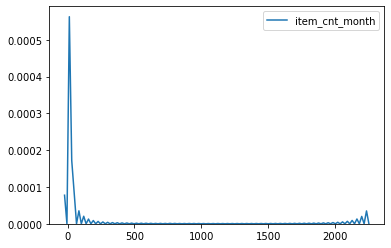

In [116]:
seaborn.kdeplot(agg_sales.item_cnt_month)

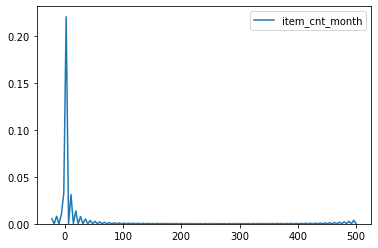

In [117]:
seaborn.kdeplot(np.clip(agg_sales.item_cnt_month,-100, 500))

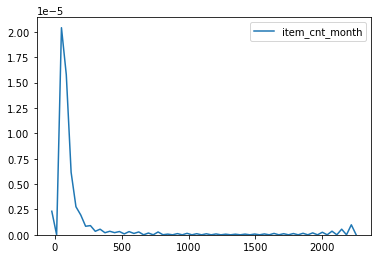

In [119]:
seaborn.kdeplot(agg_sales.item_cnt_month, gridsize=50)

Look at distribution on sales prices

In [169]:
agg_sales.head()

Month    shop_id  item_id
2013-01  0        32         221.0
                  33         347.0
                  35         247.0
                  43         221.0
                  51         128.5
Name: item_price, dtype: float64

In [130]:
price_stats = agg_sales.groupby(level=2).agg(Max=('item_price', 'max'), Min=('item_price', 'min'), Mean=('item_price', 'mean'), STD=('item_price', 'std'))
price_spread = price_stats.Max - price_stats.Min

In [123]:
price_spread.describe()

count    21806.000000
mean       284.625165
std        648.277356
min          0.000000
25%          0.000000
50%        119.000000
75%        299.000000
max      15989.000000
dtype: float64

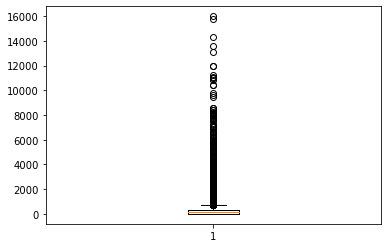

In [124]:
plt.boxplot(price_spread);

In [125]:
price_spread.sort_values(ascending=False).head(10)

item_id
7982     15989.00
7938     15727.33
7983     14291.00
13404    13590.00
13406    13091.00
13401    11989.50
13405    11982.50
14170    11229.00
7942     11072.00
6675     10999.00
dtype: float64

In [128]:
agg_sales.loc[pd.IndexSlice[:,:,7982], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2014-12 17      7982                1.0    15001.00
        37      7982                3.0    15046.25
        3       7982                2.0    15091.55
        59      7982                2.0    15091.60
        16      7982                1.0    15092.00
...                                 ...         ...
2015-04 47      7982                1.0    26692.00
2015-02 12      7982                1.0    27490.00
        27      7982                1.0    27490.00
2015-03 46      7982                2.0    28240.00
        54      7982                1.0    30990.00

[151 rows x 2 columns]

In [129]:
agg_sales.loc[pd.IndexSlice[:,:,7938], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2015-09 10      7938                1.0     1762.67
2014-05 44      7938                1.0     6798.00
2013-12 30      7938                1.0    11524.00
2013-06 56      7938                1.0    12001.00
2013-12 19      7938                2.0    12199.00
...                                 ...         ...
2013-05 54      7938                1.0    17490.00
        57      7938                2.0    17490.00
2013-04 14      7938                1.0    17490.00
2013-05 5       7938                1.0    17490.00
        25      7938                1.0    17490.00

[188 rows x 2 columns]

In [133]:
normed_var = (price_stats.STD/price_stats.Mean).fillna(0)

In [170]:
normed_var.sort_values()

item_id
0        0.000000
9430     0.000000
9429     0.000000
9428     0.000000
9427     0.000000
           ...   
11856    1.853497
11855    1.927625
11866    2.375067
11872    2.617468
11860    3.184322
Length: 21806, dtype: float64

In [141]:
agg_sales.loc[pd.IndexSlice[:,:,11860], :].sort_index(level=[1,0])

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-06,6,11860,1.0,0.1
2013-07,6,11860,2.0,0.1
2013-08,6,11860,2.0,0.1
2014-01,6,11860,1.0,58.0
2014-02,12,11860,1.0,28.0
2013-06,17,11860,4.0,0.1
2013-07,17,11860,3.0,0.1
2013-08,17,11860,1.0,0.1
2013-06,24,11860,1.0,0.1


In [137]:
items.query('item_id == 11860')

,item_name,item_id,item_category_id
11860,Змей ВАСЯ с цветком 40 см,11860,63


google translate: 'Змей ВАСЯ с цветком 40 см' --> 'SNAKE YOU with a flower 40 cm'

In [143]:
agg_sales.loc[pd.IndexSlice[:,:,11858], :].sort_values(by='item_price')

item_cnt_month  item_price
Month   shop_id item_id                            
2013-07 6       11858               8.0       0.100
2013-06 44      11858               7.0       0.100
        25      11858               4.0       0.100
        26      11858               1.0       0.100
        28      11858               1.0       0.100
...                                 ...         ...
2013-02 6       11858               1.0     139.300
2013-01 37      11858               1.0     139.300
        6       11858               3.0     169.075
        19      11858               1.0     199.000
        8       11858               1.0     199.000

[67 rows x 2 columns]

In [144]:
items.query('item_id == 11858')

,item_name,item_id,item_category_id
11858,Змей ВАСЯ с цветком 22 см,11858,63


google translate: 'Змея ВАСИЛИСА 23 см' --> 'Snake VASILISA 23 cm'

In [147]:
items.query('item_id == 20145')

,item_name,item_id,item_category_id
20145,Удавчик Плюшевый: 75см. (яйцо пластик),20145,63


google translate: 'Удавчик Плюшевый: 75см. (яйцо пластик)' --> 'Boa constrictor Plush: 75cm (egg plastic)'

In [153]:
(agg_sales.item_price == 0.1).sum()

844

In [154]:
(agg_sales.item_price <= 0.1).sum()

943

I think 0.1 is a null value for prices - will replace with median price

In [173]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

look at price counts

In [178]:
agg_sales.item_price.value_counts().head(20)

299.0     177451
149.0     160034
199.0     127417
399.0     108742
349.0      56251
249.0      48987
499.0      39628
599.0      37892
999.0      37129
699.0      31261
799.0      29823
99.0       27647
899.0      26610
1199.0     24861
549.0      23323
449.0      22382
1499.0     22229
1999.0     21080
169.0      13261
2599.0     12047
Name: item_price, dtype: int64

TODO: Create and feature, price ends in 9

<br>
<hr>
<br>

Look at distinct number of shops and items

Look at unique values

In [5]:
agg_sales.reset_index()[['Month','shop_id', 'item_id']].nunique()

Month         34
shop_id       60
item_id    21807
dtype: int64

distinct items per month per shop

In [6]:
agg_sales.reset_index().groupby('Month')[['shop_id', 'item_id']].nunique().head()

,shop_id,item_id
Month,,
2013-01,45,8115
2013-02,46,8168
2013-03,46,8302
2013-04,46,8145
2013-05,45,8339


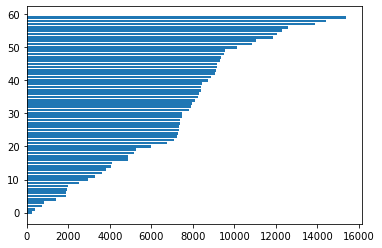

In [7]:
distinct_items_per_shop = agg_sales.reset_index().groupby('shop_id')['item_id'].nunique().sort_values()
plt.barh(range(distinct_items_per_shop.shape[0]), distinct_items_per_shop.values);

Some shops sell alot of items, and some shops sell very few - perhaps I need an encoding for shop id based on how many distinct items that shop sold

In [8]:
distinct_items_per_shop.loc[0]

3600

<br>
<hr>
<br>

Aggregate accross items and shops - and look at temporal behavior

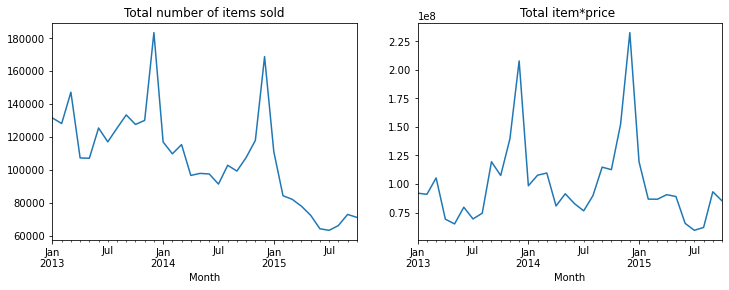

In [9]:
fig, ax  = plt.subplots(1,2)
fig.set_figwidth(12)
agg_sales.groupby(level=0).item_cnt_month.sum().plot(ax=ax[0])
ax[0].set_title('Total number of items sold')
agg_sales.groupby(level=0).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).plot(ax=ax[1])
ax[1].set_title('Total item*price ')
plt.show()

* Decembers are clearly very different from all other months. Will need to either remove, or add a feature for this.
* Also there is a clear difference between summer months and winter months (holidays?)

In [10]:
monthly_agg = agg_sales.groupby(level=0).item_cnt_month.sum()
month_of_year = monthly_agg.reset_index().Month.dt.month.rename('MOY')
month_of_year.index = monthly_agg.index
temp = pd.concat([monthly_agg, month_of_year ], axis=1)

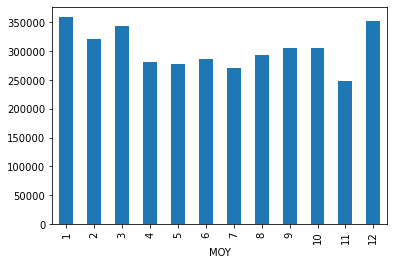

In [11]:
temp.groupby('MOY').item_cnt_month.sum().plot(kind='bar')

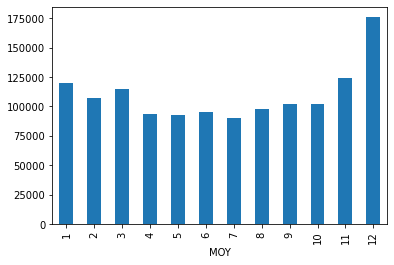

In [12]:
temp.groupby('MOY').item_cnt_month.mean().plot(kind='bar')

<br>
<hr>
<br>

## Project into items space

How many times we see each item in data set

In [13]:
item_appearances = agg_sales.groupby(level=2).item_cnt_month.count().sort_values()

In [14]:
item_appearances.head(10)

item_id
0       1
7509    1
7523    1
7537    1
7546    1
7547    1
7549    1
7550    1
7553    1
7555    1
Name: item_cnt_month, dtype: int64

In [15]:
(item_appearances == 1).sum()

2521

There are > 2000 items that we only see once! I need a feature to capture this.

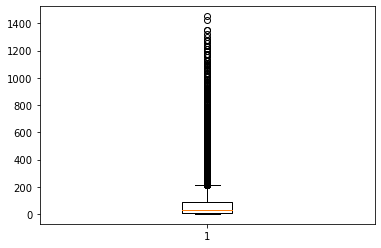

In [16]:
plt.boxplot(item_appearances);

Looks at num sales distribution accross items

In [17]:
aggregated_sales_per_item = agg_sales.groupby(level=2).item_cnt_month.sum()

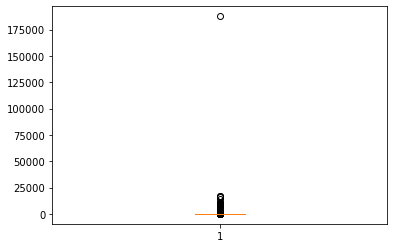

In [18]:
plt.boxplot(aggregated_sales_per_item);

In [19]:
aggregated_sales_per_item.sort_values()

item_id
1590        -11.0
13474        -1.0
11871        -1.0
18062        -1.0
13477         0.0
           ...   
5822      14515.0
17717     15830.0
3732      16642.0
2808      17245.0
20949    187642.0
Name: item_cnt_month, Length: 21807, dtype: float64

In [20]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].sort_values(by='item_cnt_month')

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-04,3,20949,1.0,5.000000
2015-09,2,20949,1.0,5.000000
2015-08,45,20949,1.0,5.000000
2015-07,52,20949,1.0,5.000000
2015-01,41,20949,1.0,5.000000
...,...,...,...,...
2014-12,25,20949,997.0,4.999769
2015-01,12,20949,1000.0,4.000000
2013-12,25,20949,1066.0,5.000000


In [21]:
items.query('item_id == 20949').item_name.values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

google says: 'Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм' -->'Branded jersey package 1C Interest white (34/42) 45 microns'

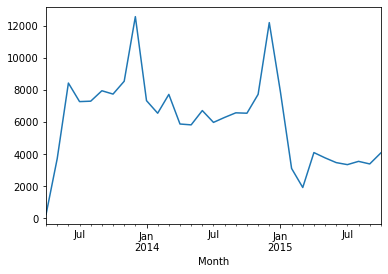

In [22]:
agg_sales.loc[pd.IndexSlice[:,:,20949], :].groupby(level=0).item_cnt_month.sum().plot()

Seems like a seasonal - winter vs summer thing

Perhaps I should create a feature for this specific item since it is sold so much more than anything else

<br>
<hr>
<br>

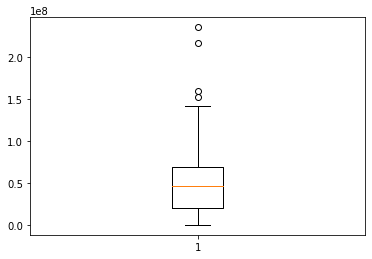

In [23]:
profit_per_shop = agg_sales.groupby(level=[0,1]).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).unstack(level=1).fillna(0)
plt.boxplot(profit_per_shop.sum().sort_values());

In [24]:
item_life = pd.concat([agg_sales.reset_index().groupby('item_id').Month.min().rename('First'),
          agg_sales.reset_index().groupby('item_id').Month.max().rename('Last')], axis=1)

In [25]:
num_months = (item_life.Last - item_life.First).apply(lambda x: x.n + 1)

In [26]:
num_months.describe()

count    21807.000000
mean        14.046270
std          9.962316
min          1.000000
25%          5.000000
50%         13.000000
75%         21.000000
max         34.000000
dtype: float64

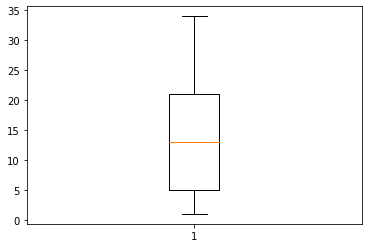

In [27]:
plt.boxplot(num_months);

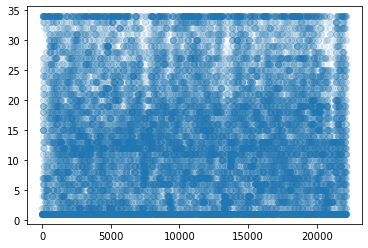

In [28]:
plt.scatter(num_months.index, num_months.values, alpha=0.1)

<br>
<hr>
<br>


Are lower priced items sold consistently more than higher priced items?

In [29]:
agg_sales.head()

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5

In [30]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

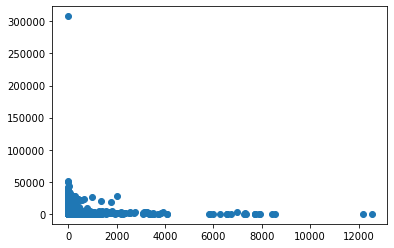

In [31]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

Is that one an outlier?

In [32]:
agg_sales.sort_values(by='item_price')

item_cnt_month     item_price
Month   shop_id item_id                               
2013-07 6       11872               1.0       0.090000
2013-06 58      11865               4.0       0.090000
        6       11864               7.0       0.094000
        58      20146               6.0       0.095833
        31      11872               8.0       0.100000
...                                 ...            ...
2015-10 22      13403               1.0   42990.000000
        3       13403               1.0   42990.000000
2015-01 12      7241                1.0   49782.000000
2014-03 25      13199               1.0   50999.000000
2013-12 12      6066                1.0  307980.000000

[1609124 rows x 2 columns]

In [33]:
items.query('item_id == 6066')

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


google says: 'Radmin 3 - 522 лиц' --> 'Radmin 3 - 522 persons'   

In [34]:
categories.query('item_category_id == 75')

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


google says: 'Программы - Для дома и офиса' --> 'Programs - For home and office'

In [35]:
idx_slice = pd.IndexSlice

In [36]:
agg_sales.loc[idx_slice[:,:,6066], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2013-12,12,6066,1.0,307980.0


In [37]:
(test_set.item_id == 6066).any()

False

Only appears once, does not appear in test set - seems like an outlier; will drop

In [38]:
items.query('item_id == 13199')

,item_name,item_id,item_category_id
13199,Коллекционные шахматы (Властелин Колец),13199,69


google says: 'Коллекционные шахматы (Властелин Колец)' --> 'Collective Chess (Lord of the Rings)'

In [39]:
categories.query('item_category_id == 69')

,item_category_name,item_category_id
69,Подарки - Сувениры,69


google says: 'Подарки - Сувениры	' --> 'Gifts - Souvenirs'

In [40]:
idx_slice = pd.IndexSlice

In [41]:
agg_sales.loc[idx_slice[:,:,13199], :]

,,,item_cnt_month,item_price
Month,shop_id,item_id,,
2014-03,25,13199,1.0,50999.0


In [42]:
(test_set.item_id == 13199).any()

False

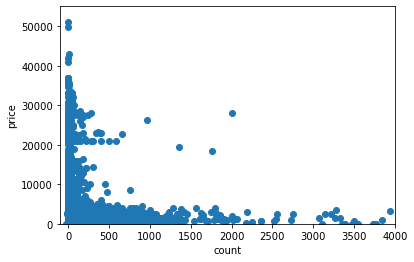

In [43]:
fig, ax = plt.subplots(1,1)
ax.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)
ax.set_xlim(-100, 4_000)
ax.set_ylim(0, 55_000)
ax.set_ylabel('price')
ax.set_xlabel('count');

No significant correlation

In [44]:
agg_sales_and_price.corr()

,item_cnt_month,item_price
item_cnt_month,1.000000,0.030912
item_price,0.030912,1.000000


Now Drop the outlier identified above

In [45]:
agg_sales = agg_sales.drop(6066, level=2)

In [46]:
agg_sales_and_price = agg_sales.groupby(level=[0,2]).agg({'item_cnt_month':sum, 'item_price':max})

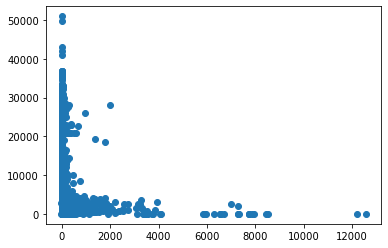

In [47]:
plt.scatter(agg_sales_and_price.item_cnt_month, agg_sales_and_price.item_price)

## Explore categories

In [48]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [50]:
items_per_category = items.groupby('item_category_id').item_id.nunique().sort_values()

In [51]:
items_per_category.head()

item_category_id
79    1
10    1
51    1
1     2
50    2
Name: item_id, dtype: int64

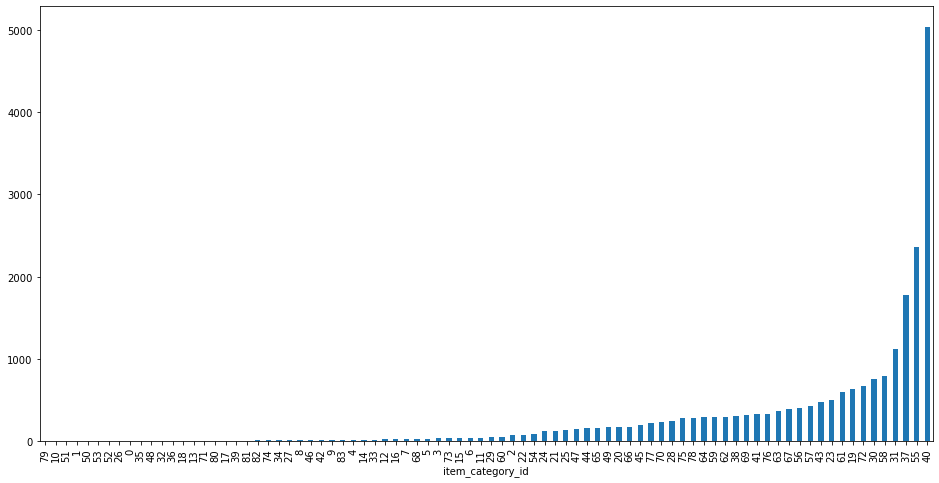

In [52]:
items_per_category.plot(kind='bar',  figsize=(16,8));

lets look at bigest category and see how sales are ditributed for items in that category

In [53]:
cat40_items = items.query('item_category_id == 40').item_id.values

In [54]:
idx = agg_sales.reset_index().item_id.isin(cat40_items)
subset = agg_sales.loc[idx.values]

In [55]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    4964.000000
mean      127.754029
std       257.226029
min         1.000000
25%        13.000000
50%        45.500000
75%       114.000000
max      3563.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [56]:
categories.query('item_category_id == 40')

,item_category_name,item_category_id
40,Кино - DVD,40


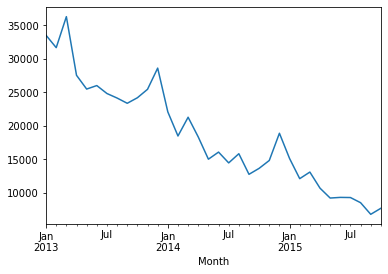

In [57]:
subset.groupby(level=0).item_cnt_month.sum().plot()

No suprise here - DVD sales have defenitely gone down recently

lets look second biggest category and see how sales are ditributed for items in that category

In [58]:
cat55_items = items.query('item_category_id == 55').item_id.values

In [59]:
idx = agg_sales.reset_index().item_id.isin(cat55_items)
subset = agg_sales.loc[idx.values]

In [60]:
subset.groupby(level=2).item_cnt_month.sum().describe()

count    2327.000000
mean      149.802750
std       233.988183
min         1.000000
25%        17.000000
50%        69.000000
75%       186.000000
max      2797.000000
Name: item_cnt_month, dtype: float64

It is a wide distribution

In [61]:
categories.query('item_category_id == 55')

,item_category_name,item_category_id
55,Музыка - CD локального производства,55


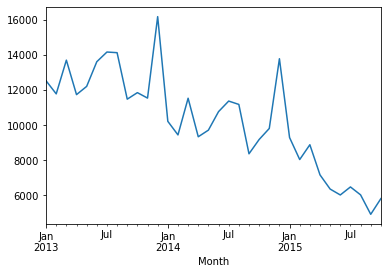

In [62]:
subset.groupby(level=0).item_cnt_month.sum().plot();

In [63]:
agg_sales

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5
...                                 ...         ...
2015-10 59      22087               6.0       119.0
                22088               2.0       119.0
                22091               1.0       179.0
                22100               1.0       629.0
                22102               1.0      1250.0

[1609123 rows x 2 columns]

In [135]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [136]:
cat_annotated_agg_sales.head()

item_cnt_month  item_price  item_category_id
Month   shop_id item_id                                              
2013-01 0       32                  6.0       221.0                40
                33                  3.0       347.0                37
                35                  1.0       247.0                40
                43                  1.0       221.0                40
                51                  2.0       128.5                57

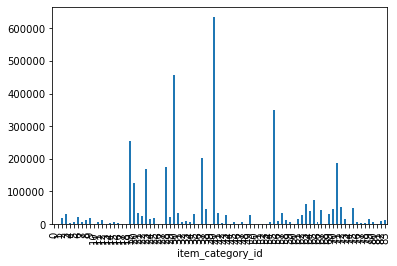

In [66]:
cat_annotated_agg_sales.groupby('item_category_id').item_cnt_month.sum().plot(kind='bar')

## Explore Shops

In [308]:
from sklearn.manifold import TSNE

In [106]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [255]:
shop_profits = agg_sales.groupby(level=[0,1]).apply(lambda x: (x.item_cnt_month*x.item_price).sum()).unstack(level=0).fillna(0)

In [258]:
shop_profits.head()

Month,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
shop_id,,,,,,,,,,,,,,,,,,,,,
0,2.966061e+06,3.670881e+06,0.000000e+00,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
1,1.527037e+06,1.710796e+06,0.000000e+00,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
2,1.086138e+06,5.231761e+05,7.378355e+05,615004.60,542550.839881,8.278706e+05,863821.975000,8.928124e+05,1.326312e+06,1.086280e+06,...,1.415131e+06,9.997728e+05,1.053243e+06,1.273795e+06,1.476925e+06,1.107731e+06,988213.915556,993776.530727,1.343664e+06,1.261611e+06
3,5.605850e+05,5.840684e+05,6.360329e+05,399608.00,470726.936364,5.208006e+05,542202.743590,5.482862e+05,1.023652e+06,7.633430e+05,...,1.226842e+06,9.025977e+05,9.560844e+05,9.611462e+05,1.147409e+06,6.770385e+05,672666.227500,753629.104667,9.532984e+05,8.160634e+05
4,1.434960e+06,1.538995e+06,1.418166e+06,202574.75,917468.718750,1.201301e+06,977240.514167,1.162317e+06,1.426126e+06,1.396139e+06,...,1.242995e+06,1.059563e+06,9.912013e+05,9.681878e+05,9.792854e+05,6.910144e+05,721250.933182,747325.038333,6.651101e+05,7.675972e+05


In [291]:
tsne = TSNE(perplexity=4).fit_transform(shop_profits)

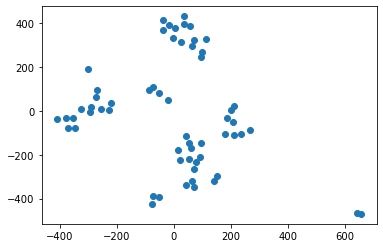

In [292]:
plt.scatter(tsne[:,0], tsne[:,1])

In [300]:
agg_sales

item_cnt_month  item_price
Month   shop_id item_id                            
2013-01 0       32                  6.0       221.0
                33                  3.0       347.0
                35                  1.0       247.0
                43                  1.0       221.0
                51                  2.0       128.5
...                                 ...         ...
2015-10 59      22087               6.0       119.0
                22088               2.0       119.0
                22091               1.0       179.0
                22100               1.0       629.0
                22102               1.0      1250.0

[1609124 rows x 2 columns]

In [306]:
shops_categories = pd.merge(agg_sales.reset_index(), items[['item_id','item_category_id']], on='item_id').groupby(['shop_id','item_category_id']).item_cnt_month.sum().unstack(level=0).fillna(0)

In [307]:
shops_categories

shop_id,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,105.0,63.0,355.0,200.0,309.0,232.0,422.0,491.0,19.0,32.0,...,733.0,231.0,250.0,341.0,874.0,0.0,338.0,669.0,324.0,223.0
3,52.0,18.0,527.0,360.0,333.0,340.0,755.0,554.0,0.0,71.0,...,773.0,247.0,376.0,460.0,1098.0,0.0,472.0,965.0,574.0,399.0
4,38.0,30.0,42.0,28.0,101.0,38.0,21.0,92.0,2.0,0.0,...,92.0,56.0,55.0,68.0,103.0,0.0,46.0,149.0,80.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.0,0.0,222.0,252.0,501.0,309.0,639.0,689.0,1.0,14.0,...,171.0,0.0,261.0,360.0,332.0,0.0,225.0,235.0,188.0,345.0
80,0.0,0.0,0.0,99.0,5.0,26.0,62.0,25.0,0.0,0.0,...,13.0,0.0,2.0,8.0,0.0,12.0,81.0,0.0,0.0,30.0
81,44.0,28.0,2.0,0.0,31.0,0.0,52.0,0.0,0.0,0.0,...,0.0,109.0,24.0,0.0,51.0,0.0,47.0,81.0,36.0,0.0


In [329]:
from sklearn.decomposition import PCA

In [335]:
pca = PCA(n_components=20).fit(shops_categories)

In [336]:
pca.explained_variance_

array([3.51288597e+08, 1.70897264e+07, 1.57195731e+07, 4.35850797e+06,
       2.99282916e+06, 1.71523243e+06, 1.24041374e+06, 8.59415832e+05,
       5.61582164e+05, 4.58240656e+05, 3.03408533e+05, 2.37597331e+05,
       2.04918466e+05, 1.50751661e+05, 1.31705431e+05, 8.89696724e+04,
       6.35857861e+04, 4.78245293e+04, 4.36940412e+04, 3.57731561e+04])

## Explore test set

In [67]:
test_set[['shop_id', 'item_id']].nunique()

shop_id      42
item_id    5100
dtype: int64

In [68]:
test_set.groupby('shop_id').item_id.nunique()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
Name: item_id, dtype: int64

When performing validation, I must do it over a set that looks like this: same items for all shops (but not the full universe of items).

I am creating such data frame now, that will be used to calculate error.

In [7]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [9]:
%%time
submission_like_df = create_submission_like_df()

Wall time: 21.4 s


In [14]:
submission_like_df.loc[agg_sales.index.levels[0][0]].reset_index().groupby('shop_id').item_id.nunique().head(10)

shop_id
0     8115
1     8115
2     8115
3     8115
4     8115
6     8115
7     8115
8     8115
10    8115
12    8115
Name: item_id, dtype: int64

# CHECKPOINT

In [1]:
import os, time
from collections import deque
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

%matplotlib inline

In [2]:
def load_sales(parse_date = True):
    data_fol = 'data'
    sales = pd.read_csv(os.path.join(data_fol, 'sales_train.csv'))
    if parse_date:
        date_col = pd.to_datetime(sales.date, format='%d.%m.%Y')
        sales.date = date_col
        sales['Month'] = sales.date.dt.to_period('M')
    return sales

def aggregate_monthly(sales_df):
    assert 'Month' in sales_df.columns, 'Month column not found'
    return (sales_df
            .groupby(['Month', 'shop_id', 'item_id'])
            .agg({'item_cnt_day': np.sum, 'item_price': np.mean})
            .rename(columns={'item_cnt_day':'item_cnt_month'})
           )

In [3]:
def load_all():
    sales = load_sales()
    agg_sales = aggregate_monthly(sales)
    items = pd.read_csv('data/items.csv')
    categories = pd.read_csv('data/item_categories.csv')
    test_set = pd.read_csv('data/test.csv')
    return sales, agg_sales, items, categories, test_set

In [4]:
def create_submission_like_df():
    months = sorted(agg_sales.index.levels[0])
    submission_like_data  = {}
    for month in months:    
        month_data = agg_sales.loc[month]
        shops = set(month_data.index.get_level_values(0))
        item_ids = set(month_data.index.get_level_values(1))

        new_idx = pd.Index(product(shops, item_ids), name=month_data.index.name)
        submission_like_data[month] = month_data.reindex(new_idx).fillna({'item_cnt_month':0, 'item_price':-1})
        
    submission_like_df = pd.concat(submission_like_data)
    submission_like_df.index.names = agg_sales.index.names
    
    return submission_like_df

In [5]:
sales, agg_sales, items, categories, test_set = load_all()

In [6]:
agg_sales = agg_sales.drop(6066, level=2)

In [7]:
agg_sales.loc[agg_sales.item_price <= 0.1, 'item_price'] = np.nan
agg_sales['item_price'] = agg_sales.groupby(level=2).item_price.transform(lambda x: x.fillna(x.mean()))

In [8]:
cat_annotated_agg_sales = (pd.merge(agg_sales.reset_index(), items.drop('item_name', axis=1), on='item_id')
                           .set_index(['Month', 'shop_id', 'item_id'])
                           .sort_index(level=[0,1,2])
                          )

In [9]:
submission_like_df = create_submission_like_df()

In [10]:
months = sorted(agg_sales.index.levels[0])

# Simple Linear Model
Used for ensembling

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [74]:
ext_agg_sales  = agg_sales.copy().drop('item_price', axis=1)
ext_agg_sales['total_shop_cnt_month'] = agg_sales.groupby(level=[0,1]).item_cnt_month.transform('sum')
ext_agg_sales['total_item_cnt_month'] = agg_sales.groupby(level=[0,2]).item_cnt_month.transform('sum')

In [76]:
shops = sorted(ext_agg_sales.index.levels[1])
idx_cols = ['Month', 'item_id']
cols_to_lag = ['item_cnt_month', 'total_shop_cnt_month', 'total_item_cnt_month']

In [113]:
def get_single_shop_data(shopnum):
    lag_month_map = dict(zip(months, months[1:]))
    forward_month_map = dict(zip(months[1:], months))

    def rename_col(col, s):
        return f'{col}_lag_{s}'

    single_shop = ext_agg_sales.loc[pd.IndexSlice[:,shopnum,:],:].reset_index(level=1, drop=True).reset_index()

    shifted = [single_shop.copy().dropna().set_index(idx_cols)]
    for shift in [1,2,3,4,5,8,11]:
        single_shop_shift = single_shop.copy()
        month = single_shop.Month
        for s in range(1,shift+1):
            month = month.map(lag_month_map)
        single_shop_shift.Month = month
        single_shop_shift.columns = [rename_col(col, shift) if col in cols_to_lag else col for col in single_shop_shift.columns ]
        shifted.append(single_shop_shift.dropna().set_index(idx_cols))

    all_data_single_shop = pd.concat(shifted, axis=1).fillna(0)
    single_shop_target = single_shop.copy()
    single_shop_target.Month = single_shop_target.Month.map(forward_month_map)
    all_data_single_shop['target'] = single_shop_target.dropna().set_index(idx_cols).item_cnt_month
    all_data_single_shop = all_data_single_shop.loc[months[12:]] # remove first 12 months with incomplete features
    
    return all_data_single_shop

In [132]:
def get_single_shop_predictions(mod, all_data_single_shop):
    out_sample_preds = []
    for (train_month_thresh, test_month) in zip(months[12:-1], months[13:]):
        X_train, Y_train = (all_data_single_shop.loc[:train_month_thresh].drop('target', axis=1), all_data_single_shop.loc[:train_month_thresh, 'target'])
        X_test, Y_test = (all_data_single_shop.loc[[test_month]].drop('target', axis=1), all_data_single_shop.loc[[test_month], 'target'])
        if (len(X_test) == 0) or (len(X_train) == 0):
            continue
        fitted_model = mod.fit(X_train, Y_train.fillna(0))
        ytest_pred = fitted_model.predict(X_test)
        out_sample_preds.append(pd.Series(ytest_pred, index=X_test.index))
        #print(f'Test month: {test_month}, Test R-squared is: {r2_score(Y_test, ytest_pred)}' )
    if out_sample_preds:
        return pd.concat(out_sample_preds)
    else:
        return None


In [134]:
%%time
mod = LinearRegression()
shops_pred = {}
for shop in shops:
    single_shop_data = get_single_shop_data(shop)
    preds =  get_single_shop_predictions(mod, single_shop_data)
    if preds is not None:
        shops_pred[shop] = preds
    

Wall time: 4min 3s


In [146]:
shops_pred_df = pd.concat(shops_pred, names=['shop_id']).swaplevel(0,1).unstack(level=0).fillna(0)

In [148]:
month = shops_pred_df.columns[0]

In [153]:
month_preds = shops_pred_df[month]

In [155]:
r2_score(objectives[month], month_preds.reindex(objectives[month].index).fillna(0))

0.6174194335120204

# Built-out XGB Model

# Feature Generation

In [11]:
piv_agg_sales = agg_sales.item_cnt_month.unstack(level=0).fillna(0).sort_index()

In [12]:
piv_agg_sales.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

Reduce data foot print

In [13]:
piv_agg_sales = piv_agg_sales.astype(int)

In [14]:
preprocessed_data = piv_agg_sales

## Sales Moving Averages

In [15]:
half_lifes = [1,2,3,6,9,12]

In [16]:
%%time
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std().astype(np.float32) for tau in half_lifes}

Wall time: 32.2 s


In [17]:
%%time
prices = agg_sales.item_price.unstack(level=0).fillna(0)
shop_monthly_income = (prices*preprocessed_data).groupby(level=0).transform('sum')
item_monthly_income = (prices*preprocessed_data).groupby(level=1).transform('sum')
items_income_ewms = {tau:item_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
shops_income_ewms = {tau:shop_monthly_income.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

del(prices, shop_monthly_income, item_monthly_income)

Wall time: 33.8 s


### Rolling stats

In [18]:
windows = [3,6,9,12]

In [19]:
%%time
sales_rmin = {w:preprocessed_data.rolling(window=2, axis=1).min().astype(np.float32) for w in windows}
sales_rmedian = {w:preprocessed_data.rolling(window=2, axis=1).median().astype(np.float32) for w in windows}
sales_rmax = {w:preprocessed_data.rolling(window=2, axis=1).max().astype(np.float32) for w in windows}

Wall time: 2min 25s


## Mean Encode Shops

In [20]:
%%time
target_encode_shops_itemCounts = preprocessed_data.groupby(level=0).transform('sum')
target_encode_shops_uniqueItems = preprocessed_data.groupby(level=0).transform(lambda x: (x>0).sum())
target_encode_shops_soldAnything = target_encode_shops_uniqueItems.astype(bool).astype(int)

targenc_shops_itemCounts_ewms = {tau:target_encode_shops_itemCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
targenc_shops_uniqueItems_ewms = {tau:target_encode_shops_uniqueItems.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}
target_encode_shops_soldAnything_ewms = {tau:target_encode_shops_soldAnything.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

del(target_encode_shops_itemCounts, target_encode_shops_uniqueItems, target_encode_shops_soldAnything)

Wall time: 44.5 s


## Encode Items

First item map to category, and encode how many items in that category sold that month

In [21]:
cat_sales = cat_annotated_agg_sales.groupby(['Month','item_category_id']).item_cnt_month.transform('sum')
cat_sales = cat_sales.unstack(level=0).fillna(0)
targenc_cat_sales = {tau:cat_sales.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [22]:
did_item_sell_that_month = piv_agg_sales.groupby('item_id').transform('max').astype(bool).astype(int)
sales_bool_rsum = {w:did_item_sell_that_month.rolling(window=w, axis=1).sum().astype(np.float32) for w in windows}

In [23]:
target_encode_items_totalMonthCounts = preprocessed_data.groupby(level=1).transform('sum')
targenc_items_totalMonthCounts_ewms = {tau:target_encode_items_totalMonthCounts.ewm(halflife=tau, axis=1, min_periods=tau).mean().astype(np.float32) for tau in half_lifes}

In [24]:
del(cat_sales, did_item_sell_that_month, target_encode_items_totalMonthCounts)

## Price related features

In [25]:
endsIn9 = agg_sales.item_price.transform(lambda x: x%10 == 9).unstack(level=0).fillna(False).reindex(preprocessed_data.index)

## Date Related features

In [26]:
import calendar

In [27]:
extended_months = months+[pd.Period('2015-11')]
hols2013 = [8,2,2,0,7,3,1,2,2,1,2,3]
hols2014 = [10,3,4,1,8,7,2,0,2,2,4,1]
hols2015 = [11,3,3,1,5,3,2,0,3,1,1,2]
holidadys = hols2013 + hols2014 + hols2015
month_holidays = dict(zip(extended_months, holidadys))

In [28]:
vals = {}
for mon in extended_months:
    cal = calendar.monthcalendar(mon.year, mon.month)
    total_days = (np.array(cal).flatten() != 0).sum()
    num_mondays = sum([1 for week in cal if week[0] != 0])
    num_tuesdays = sum([1 for week in cal if week[1] != 0])
    num_wednesdays = sum([1 for week in cal if week[2] != 0])
    num_thursdays = sum([1 for week in cal if week[3] != 0])
    num_fridays = sum([1 for week in cal if week[4] != 0])
    num_saturdays = sum([1 for week in cal if week[5] != 0])
    num_sundays = sum([1 for week in cal if week[6] != 0])
    vals[mon] = pd.Series({'total_days': total_days, 'mondays':num_mondays, 'tuesdays':num_tuesdays, 'wednesdays':num_wednesdays, 'thursdays':num_thursdays, 'fridays':num_fridays, 'saturdays':num_saturdays, 'sundays':num_sundays})

In [29]:
month_decomp = pd.concat([pd.concat(vals, axis=1).T, pd.Series(month_holidays, name='holidays')], axis=1)
month_decomp['num_weekends'] = month_decomp[['saturdays', 'sundays']].sum(axis=1)
month_decomp['num_weekdays'] = month_decomp.total_days - month_decomp.num_weekends

In [30]:
month_decomp = month_decomp.astype(np.int32)

In [31]:
month_decomp.head()

,total_days,mondays,tuesdays,wednesdays,thursdays,fridays,saturdays,sundays,holidays,num_weekends,num_weekdays
2013-01,31,4,5,5,5,4,4,4,8,8,23
2013-02,28,4,4,4,4,4,4,4,2,8,20
2013-03,31,4,4,4,4,5,5,5,2,10,21
2013-04,30,5,5,4,4,4,4,4,0,8,22
2013-05,31,4,4,5,5,5,4,4,7,8,23


## Advanced Features

###  - KMeans

In [32]:
from sklearn.cluster import KMeans

Note that I am using the entire data set to find the groups - this means that there is some future peaking. But I will use only causal data to obtain the features, so it shouldn't be too bad.

In [33]:
shop_cat = cat_annotated_agg_sales.reset_index().groupby(['shop_id', 'item_category_id']).item_cnt_month.sum().unstack(level=1).fillna(0)

In [34]:
kmeans = KMeans(n_clusters=3).fit(shop_cat)

In [35]:
pd.Series(kmeans.labels_).value_counts()

1    33
0    22
2     5
dtype: int64

In [36]:
shop_id_map = dict(zip(shop_cat.index, kmeans.labels_))
kmeans_idx = piv_agg_sales.index.get_level_values(0).map(shop_id_map)

In [37]:
kgrouped = piv_agg_sales.groupby([kmeans_idx, piv_agg_sales.index.get_level_values(1)])
kgrouped_means = kgrouped.transform('mean')
kgrouped_stds = kgrouped.transform('std').fillna(0)
kgrouped_meds = kgrouped.transform('median')

In [38]:
kgrouped_means_ewms = {tau:kgrouped_means.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_stds_ewms = {tau:kgrouped_stds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
kgrouped_meds_ewms = {tau:kgrouped_meds.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

In [39]:
del(shop_cat, kgrouped, kgrouped_means, kgrouped_stds, kgrouped_meds)

### Shop-Category interaction

Idea here is to create a feature that captures the interaction between shop and category, and then do a mean encoding. But I will do both in one step by simply grouping by shop $\times$ category

In [40]:
item_cat_map = items.set_index('item_id').item_category_id
cat_idx = piv_agg_sales.index.get_level_values('item_id').map(item_cat_map)

In [41]:
%%time
shop_cat_mean = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('mean')
shop_cat_std = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('std').fillna(0)
shop_cat_med = piv_agg_sales.groupby([piv_agg_sales.index.get_level_values('shop_id'), cat_idx]).transform('median')

Wall time: 1.98 s


In [42]:
%%time
shopcat_means_ewms = {tau:shop_cat_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
shopcat_stds_ewms = {tau:shop_cat_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
shopcat_meds_ewms = {tau:shop_cat_med.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 42.9 s


In [43]:
del(shop_cat_mean, shop_cat_std, shop_cat_med)

### Month-Category Interaction

In [44]:
cat_idx

Int64Index([40, 37, 40, 37, 40, 37, 57, 57, 40, 57,
            ...
            38, 37, 37, 40, 37, 37, 37, 40, 37, 49],
           dtype='int64', name='item_id', length=424123)

In [45]:
cat_month_sum = piv_agg_sales.groupby(cat_idx).transform('sum')
cat_month_mean = piv_agg_sales.groupby(cat_idx).transform('mean')
cat_month_std = piv_agg_sales.groupby(cat_idx).transform('std')

In [46]:
%%time
catmonth_sum_ewms = {tau:cat_month_sum.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_mean_ewms = {tau:cat_month_mean.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}
catmonth_std_ewms = {tau:cat_month_std.ewm(halflife=tau, axis=1).mean().astype(np.float32) for tau in half_lifes}

Wall time: 42.2 s


In [47]:
del(cat_month_sum, cat_month_mean,cat_month_std )

## Creating Objective

In [48]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

## Putting Features together and adding date features

In [49]:
sales_mean_features = {f'sales_ewms_mean_ewms{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_ewms{tau}': sales_ewms_std[tau] for tau in half_lifes}

items_income_features = {f'items_income_ewms{tau}': items_income_ewms[tau] for tau in half_lifes}
shops_income_features = {f'shops_income_ewms{tau}': shops_income_ewms[tau] for tau in half_lifes}

sales_rmin_features = {f'sales_rmin{w}':sales_rmin[w] for w in windows}
sales_rmedian_features = {f'sales_rmed{w}':sales_rmedian[w] for w in windows}
sales_rmax_features = {f'sales_rmax{w}':sales_rmax[w] for w in windows}

targenc_shops_itemCounts_feats = {f'targenc_shops_itmCnts_ewms{tau}':targenc_shops_itemCounts_ewms[tau] for tau in half_lifes}
targenc_shops_uniqueItems_feats = {f'targenc_shops_uniqItms_ewms{tau}':targenc_shops_uniqueItems_ewms[tau] for tau in half_lifes}
targenc_shops_soldAnything_ewms = {f'targenc_shops_soldAnything_ewms{tau}':target_encode_shops_soldAnything_ewms[tau] for tau in half_lifes}

targenc_cat_sales_feats = {f'targenc_items_catMonthSales_ewms{tau}':targenc_cat_sales[tau] for tau in half_lifes}
sales_bool_rsum_feats = {f'targenc_items_boolMonthSales_rsum{w}':sales_bool_rsum[w] for w in windows}
targenc_items_totalMonthCounts_ewms_feats = {f'targenc_items_totalMnthCnt_ewms{tau}':targenc_items_totalMonthCounts_ewms[tau] for tau in half_lifes}

kgrouped_means_feats = {f'kgrp_mean_ewms{tau}':kgrouped_means_ewms[tau] for tau in half_lifes}
kgrouped_stds_feats = {f'kgrp_stds_ewms{tau}':kgrouped_stds_ewms[tau] for tau in half_lifes}
kgrouped_meds_feats = {f'kgrp_meds_ewms{tau}':kgrouped_meds_ewms[tau] for tau in half_lifes}

shopcat_means_feats = {f'shopcat_mean_ewms{tau}':shopcat_means_ewms[tau] for tau in half_lifes}
shopcat_stds_feats = {f'shopcat_stds_ewms{tau}':shopcat_stds_ewms[tau] for tau in half_lifes}
shopcat_meds_feats = {f'shopcat_meds_ewms{tau}':shopcat_meds_ewms[tau] for tau in half_lifes}

catmonth_sum_feats = {f'catmonth_sum_ewms{tau}':catmonth_sum_ewms[tau] for tau in half_lifes}
catmonth_mean_feats = {f'catmonth_mean_ewms{tau}':catmonth_mean_ewms[tau] for tau in half_lifes}
catmonth_std_feats = {f'catmonth_std_ewms{tau}':catmonth_std_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features,
                 **items_income_features, **shops_income_features,
                 **sales_rmin_features, **sales_rmedian_features, **sales_rmax_features,
                 **targenc_shops_itemCounts_feats, **targenc_shops_uniqueItems_feats, **targenc_shops_soldAnything_ewms,
                 **targenc_cat_sales_feats, **sales_bool_rsum_feats, **targenc_items_totalMonthCounts_ewms_feats,
                 **kgrouped_means_feats, **kgrouped_stds_feats, **kgrouped_meds_feats,
                 **shopcat_means_feats, **shopcat_stds_feats, **shopcat_meds_feats,
                 **catmonth_sum_feats, **catmonth_mean_feats, **catmonth_std_feats,
                }

features_dict['PriceEndsIn9'] = endsIn9

Helper function to get features for a single month of data

In [50]:
all_months = preprocessed_data.columns.tolist()
obj_month_map = dict(zip(all_months[:-1], all_months[1:]))

def get_single_month_XY(month_, drop_cols = None, num_lagged_values=0):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    try:
        submission_Y = submission_like_df.item_cnt_month.loc[obj_month_map[month_]]
    except KeyError:
        submission_Y = None
    
    if num_lagged_values > 0:
        idx = np.argmax(preprocessed_data.columns == month_)
        assert idx >= num_lagged_values, "do not have enough columns for desired lags"
        lagged_vals = preprocessed_data.iloc[:,idx-num_lagged_values:idx]
        lagged_vals.columns = [f'lag{lag}' for lag in list(range(1,num_lagged_values+1))[::-1]]
        X = pd.concat([X,lagged_vals], axis=1)
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    X['winter'] = X.month.map({**dict(zip([4,5,6,7,8,9,10], [False]*7)), **dict(zip([1,2,3,11,12], [True]*5))})
    # add more date related features
    current_vals = month_decomp.loc[month_].values
    next_month_vals = month_decomp.shift(-1).loc[month_].astype(int).values
    broadcast_mask = np.ones(X.shape[0], dtype=int)[:,None]
    current_vals = pd.DataFrame(current_vals[None,:] * broadcast_mask, index=X.index, columns=month_decomp.columns)
    next_month_vals = pd.DataFrame(next_month_vals[None,:] * broadcast_mask, index=X.index, columns=['nm_'+col for col in month_decomp.columns])
    X = pd.concat([X, current_vals, next_month_vals], axis=1)
    
    
    if drop_cols is not None:
        X = X.drop(drop_cols, axis=1)
    
    X = pd.concat([X], keys=[month_], names=['Period'])
    Y = pd.concat([Y], keys=[month_], names=['Period'])
    if submission_Y is not None:
        submission_Y = pd.concat([submission_Y], keys=[month_], names=['Period'])
    
    return X,Y, submission_Y

In [51]:
X,Y, _ = get_single_month_XY(all_months[-1])

In [52]:
X.shape

(424123, 150)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 424123 entries, (Period('2015-10', 'M'), 0, 30) to (Period('2015-10', 'M'), 59, 22167)
Columns: 150 entries, sales_ewms_mean_ewms1 to nm_num_weekdays
dtypes: bool(2), float32(124), int32(22), int64(2)
memory usage: 245.3 MB


# Simple Model

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [55]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    fitted_model.col_names = x_train.columns
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    return fitted_model, y_train_pred, y_val_pred, fit_time

In [56]:
def plot_feature_importances(mod, figsize=(6,10)):
    plt.figure(figsize=figsize)
    importances = mod.feature_importances_
    if type(importances) == pd.Series:
        importances.sort_values().plot(kind='barh')
    else:
        pd.Series(importances, index=mod.col_names).sort_values().plot(kind='barh')


In [57]:
def conform_to_subY(x, y_pred, y_sub_ser, fill_value=0):
    y_pred_ser = pd.Series(y_pred, index=x.index)
    y_pred_ser = y_pred_ser.reindex(y_sub_ser.index).fillna(0)
    return y_pred_ser
    

In [58]:
%%time
X_train, Y_train, Y_sub = get_single_month_XY(months[15])

Wall time: 1.41 s


In [63]:
X_train.shape

(424123, 110)

In [64]:
X_train.head()

sales_ewms_mean_ewms1  sales_ewms_mean_ewms2  \
Period  shop_id item_id                                                 
2014-04 0       30                    0.000946               0.071213   
                31                    0.000336               0.025269   
                32                    0.000397               0.032718   
                33                    0.000137               0.011765   
                35                    0.000443               0.033785   

                         sales_ewms_mean_ewms3  sales_ewms_mean_ewms6  \
Period  shop_id item_id                                                 
2014-04 0       30                    0.258203               0.796550   
                31                    0.091620               0.282647   
                32                    0.122956               0.394302   
                33                    0.044820               0.145761   
                35                    0.123219               0.382624   

                         sales_ewms_mean_ewms9  sales_ewms_mean_ewms12  \
Period  shop_id item_id                                                  
2014-04 0       30                    1.103571                1.284981   
                31                    0.391590                0.455961   
                32                    0.553752                0.649257   
                33                    0.205678                0.241727   
                35                    0.531347                0.619438   

                         sales_ewms_std_ewms1  sales_ewms_std_ewms2  \
Period  shop_id item_id                                               
2014-04 0       30                   0.209741              1.631878   
                31                   0.074424              0.579054   
                32                   0.073495              0.589200   
                33                   0.024859              0.206169   
                35                   0.094842              0.738221   

                         sales_ewms_std_ewms3  sales_ewms_std_ewms6  ...  \
Period  shop_id item_id                                              ...   
2014-04 0       30                   3.004810              5.111737  ...   
                31                   1.066223              1.813842  ...   
                32                   1.095871              1.875348  ...   
                33                   0.388150              0.672201  ...   
                35                   1.359115              2.309914  ...   

                         shopcat_meds_ewms1  shopcat_meds_ewms2  \
Period  shop_id item_id                                           
2014-04 0       30                 0.000046            0.003922   
                31                 0.000046            0.003922   
                32                 0.000046            0.003922   
                33                 0.000046            0.003922   
                35                 0.000046            0.003922   

                         shopcat_meds_ewms3  shopcat_meds_ewms6  \
Period  shop_id item_id                                           
2014-04 0       30                  0.01494            0.048587   
                31                  0.01494            0.048587   
                32                  0.01494            0.048587   
                33                  0.01494            0.048587   
                35                  0.01494            0.048587   

                         shopcat_meds_ewms9  shopcat_meds_ewms12  \
Period  shop_id item_id                                            
2014-04 0       30                 0.068559             0.080576   
                31                 0.068559             0.080576   
                32                 0.068559             0.080576   
                33                 0.068559             0.080576   
                35                 0.068559             0.080576   

                         PriceEnds

In [65]:
Y_train.head()

Period   shop_id  item_id
2014-04  0        30         0.0
                  31         0.0
                  32         0.0
                  33         0.0
                  35         0.0
Name: 2014-04, dtype: float64

In [66]:
Y_sub.head()

Period   shop_id  item_id
2014-04  2        27         0.0
                  30         1.0
                  31         1.0
                  32         0.0
                  33         0.0
Name: item_cnt_month, dtype: float64

Try simple random forrest

In [67]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train)

In [68]:
elapsed, np.sqrt(mean_squared_error(Y_train, ytpred))

(103.52635431289673, 1.2587828968299464)

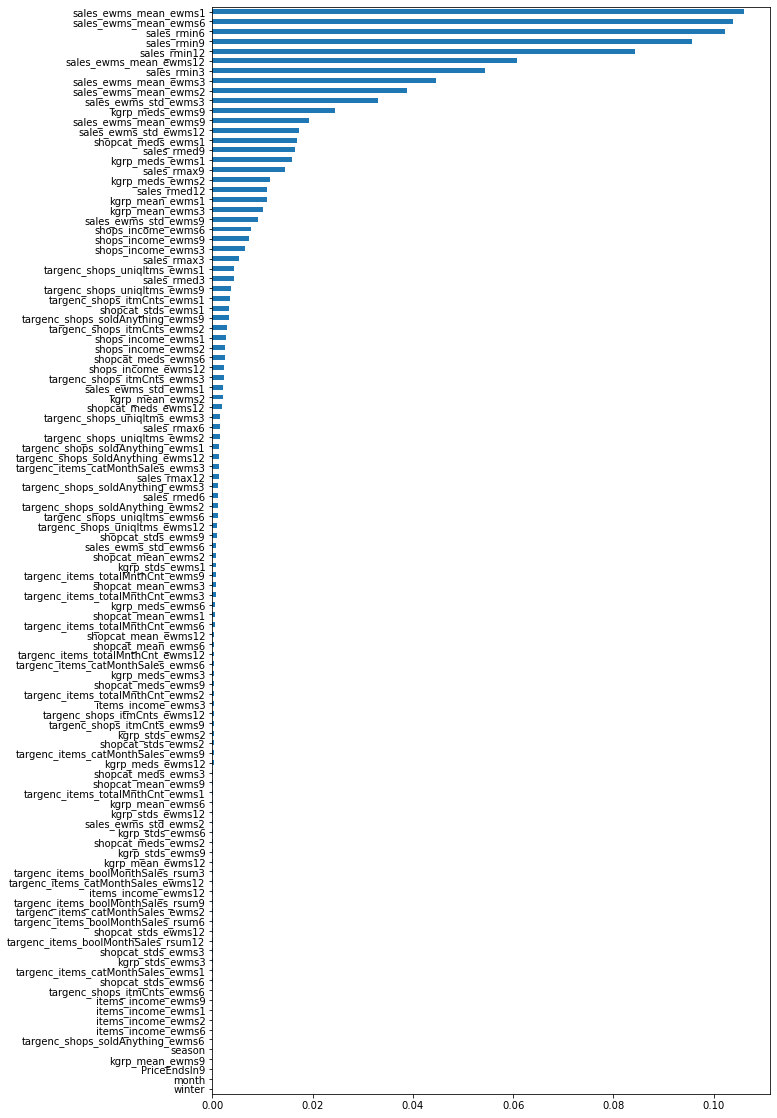

In [69]:
plot_feature_importances(fitted, figsize=(10,20))

In [59]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'lambda':1,
            'gamma':0.1,
            'objective':'reg:squarederror',
            # leave nthread default - detects all cores automatically
        }
        self.params.update(params)
        self.fitted_model = None
        self.num_boost_round = num_boost_round
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train, num_boost_round=self.num_boost_round)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    @property
    def feature_importances_(self):
        return pd.Series(self.fitted_model.get_score(importance_type='weight'))

## Tune Prediction Clipping

In [42]:
%%time
X_val, Y_val, Y_val_sub = get_single_month_XY(months[16])

Wall time: 994 ms


In [43]:
yval_pred = fitted.predict(X_val)

In [44]:
yval_pred = conform_to_subY(X_val, yval_pred, Y_val_sub)

In [54]:
errors = {}
for i in range(10, 1000, 50):
    errors[i] = np.sqrt(mean_squared_error(Y_val_sub, np.clip(0, i, yval_pred)))

In [55]:
pd.Series(errors)

10     2.642167
60     2.328842
110    2.142520
160    1.994654
210    1.859386
260    1.740896
310    1.674206
360    1.620620
410    1.586119
460    1.569519
510    1.569519
560    1.569519
610    1.569519
660    1.569519
710    1.569519
760    1.569519
810    1.569519
860    1.569519
910    1.569519
960    1.569519
dtype: float64

In [56]:
np.sqrt(mean_squared_error(Y_val_sub, yval_pred))

1.569518923117131

From this simple experiment it seems like no clipping prediction is better - will test against other months in more depth later

# Rolling Cross Validation

Description if Cross of Model Fit and Cross Validation:

In [60]:
class results:
    def __init__(self, model, fitted_models, preSub_is_scores, preSub_oos_scores, is_scores, os_scores, times=None):
        self.model = model
        self.fitted_models = fitted_models
        self.preSub_is_scores = preSub_is_scores
        self.preSub_oos_scores = preSub_oos_scores
        self.is_scores = is_scores
        self.os_scores = os_scores
        self.times = times
        
    @property
    def keys(self):
        return sorted(self.fitted_models.keys())
        
    @property
    def scores(self):
        return pd.concat([pd.Series(self.preSub_is_scores, name='PreInSampleRMSE'), pd.Series(self.is_scores, name='inSampleRMSE'), pd.Series(self.preSub_oos_scores, name='PreOutSampleRMSE'), pd.Series(self.os_scores, name='outSampleRMSE')], axis=1)
        

In [61]:
def rolling_cross_validation(model, data_months_list, post_process_preds = None, num_lagged_values=12, validate_months_num=None, num_stack_months=1, pred_fill_value=0, fit_final=False, drop_cols=None):
    if post_process_preds is None:
        post_process_preds = lambda x: x
        
    Xs_deque = deque()
    Ys_deque = deque()
    Ysubs_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_, Ysub_= get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        Ysubs_deque.append(Ysub_)
        
           
    max_validate_months = len(data_months_list) - num_stack_months - 1
    if validate_months_num is None:
        validate_months_num = max_validate_months
    else:
        validate_months_num = min(validate_months_num, max_validate_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    prepred_is_scores = {}
    prepred_os_scores = {}
    loop_times = []
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        X_val, Y_val, Y_sub_val = get_single_month_XY(month, drop_cols=drop_cols, num_lagged_values=num_lagged_values)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        prepred_is_scores[month] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        prepred_os_scores[month] = np.sqrt(mean_squared_error(Y_val, yval_pred))
        
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        yval_pred = conform_to_subY(X_val, yval_pred, Y_sub_val, fill_value=pred_fill_value)
        
        ytrain_pred = post_process_preds(ytrain_pred)
        yval_pred = post_process_preds(yval_pred)
        
        in_sample_scores[month] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
        oos_scores[month] = np.sqrt(mean_squared_error(Y_sub_val, yval_pred))
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        Ysubs_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        Ysubs_deque.append(Y_sub_val)

        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        Y_sub_train = pd.concat(Ysubs_deque)
        
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        prepred_is_scores['FINAL'] = np.sqrt(mean_squared_error(Y_train, ytrain_pred))
        ytrain_pred = conform_to_subY(X_train, ytrain_pred, Y_sub_train, fill_value=pred_fill_value)
        ytrain_pred = post_process_preds(ytrain_pred)
        in_sample_scores['FINAL'] = np.sqrt(mean_squared_error(Y_sub_train, ytrain_pred))
    
    return results(model, fitted_models, prepred_is_scores, prepred_os_scores, in_sample_scores, oos_scores, loop_times) #, Xs, ys, yprepreds, ypreds)

## XGB

In [61]:
mod = xgb_model(num_boost_round=10, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 293.44590973854065
Working on: 2015-08
fit time: 922.5040299892426
Working on: 2015-09
fit time: 291.43268370628357


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.795194,2.174788,1.199953,1.561052
2015-08,1.799650,2.212383,4.546681,6.326111
2015-09,1.826877,2.274102,3.668091,4.824855
FINAL,1.777474,2.246065,NaN,NaN


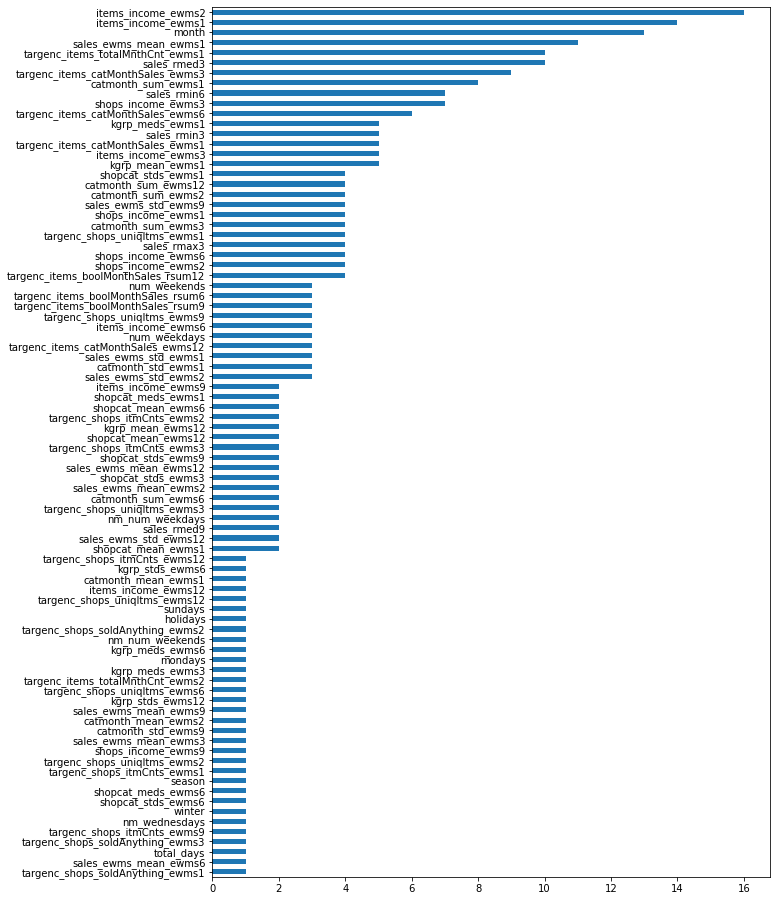

In [63]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [64]:
mod = xgb_model(num_boost_round=10, max_depth=10, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 397.44608998298645
Working on: 2015-08
fit time: 400.73388624191284
Working on: 2015-09
fit time: 479.15761613845825


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.572039,1.896147,1.319272,1.623839
2015-08,1.554879,1.905774,4.501232,6.258807
2015-09,1.544922,1.918274,3.547087,4.625835
FINAL,1.472215,1.852895,NaN,NaN


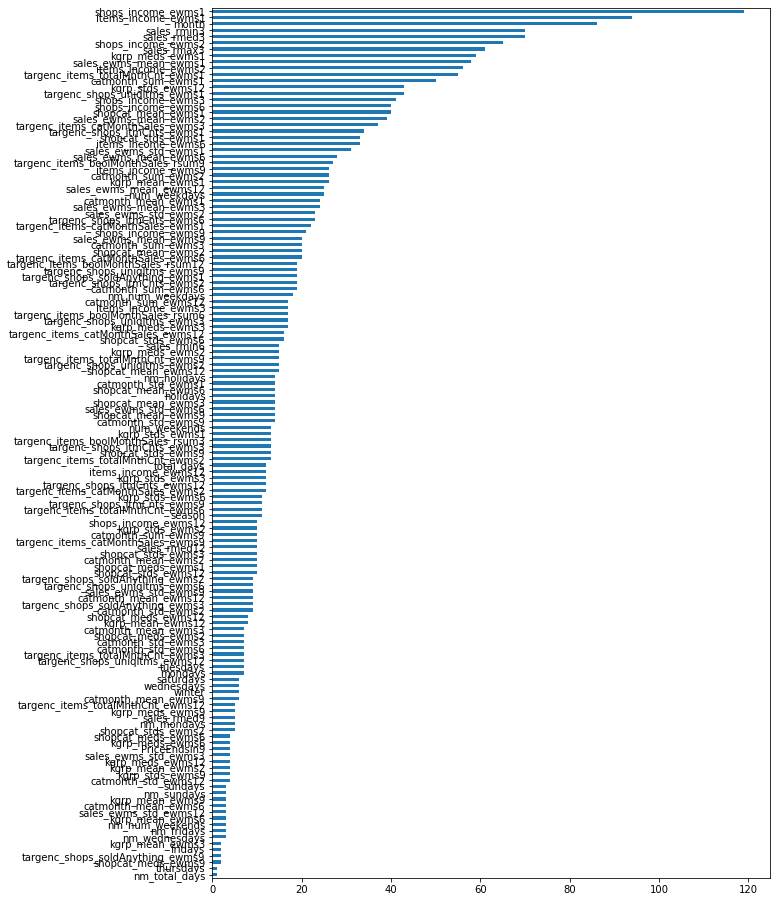

In [65]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [62]:
mod = xgb_model(num_boost_round=10, max_depth=15, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 356.1450295448303
Working on: 2015-08
fit time: 370.2810392379761
Working on: 2015-09
fit time: 342.8974413871765


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.476520,1.763173,1.156126,1.531330
2015-08,1.462438,1.771716,4.439922,6.171452
2015-09,1.451440,1.783400,3.466386,4.560253
FINAL,1.371354,1.708229,NaN,NaN


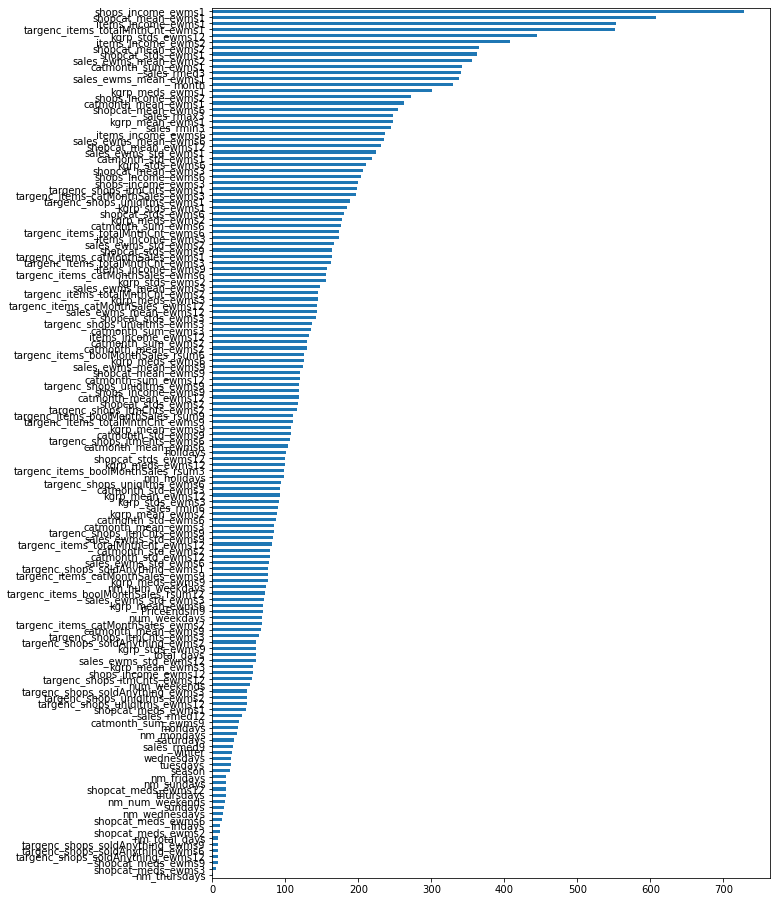

In [63]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [64]:
mod = xgb_model(num_boost_round=10, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 386.3203811645508
Working on: 2015-08
fit time: 403.77485609054565
Working on: 2015-09
fit time: 593.7136771678925


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.433695,1.706788,1.317404,1.711749
2015-08,1.421504,1.720194,4.456178,6.199968
2015-09,1.406951,1.722454,3.595733,4.745537
FINAL,1.322435,1.642241,NaN,NaN


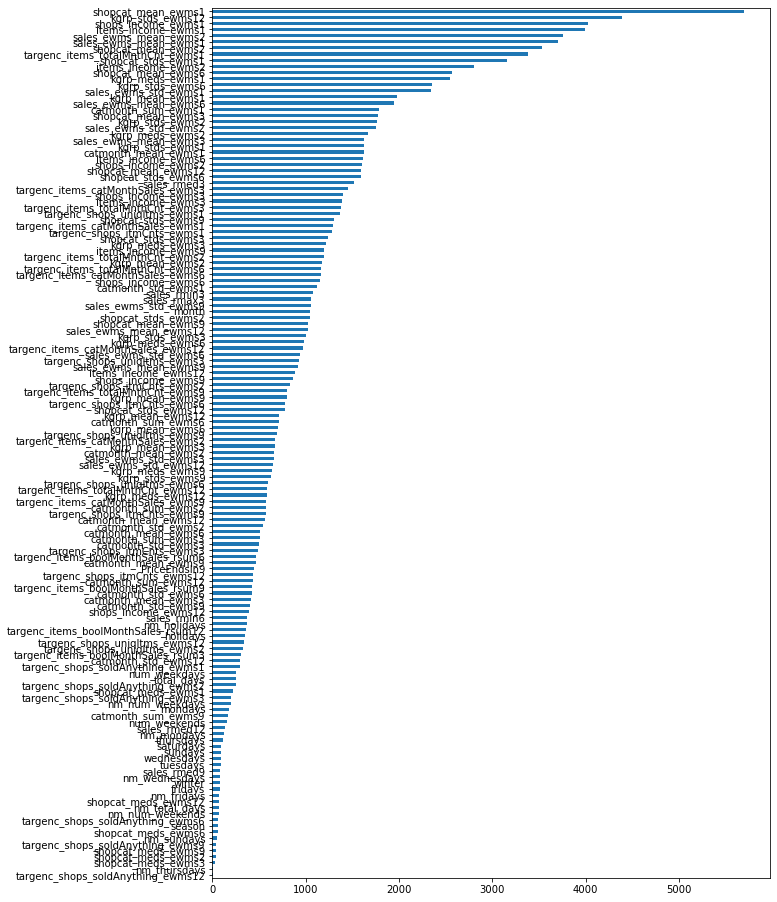

In [65]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [66]:
mod = xgb_model(num_boost_round=50, max_depth=20, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 470.8373017311096
Working on: 2015-08
fit time: 451.8639121055603
Working on: 2015-09
fit time: 472.445921421051


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.371122,1.626453,1.25518,1.640144
2015-08,1.365877,1.647695,4.47088,6.211698
2015-09,1.331756,1.628861,3.28619,4.259613
FINAL,1.218694,1.506988,NaN,NaN


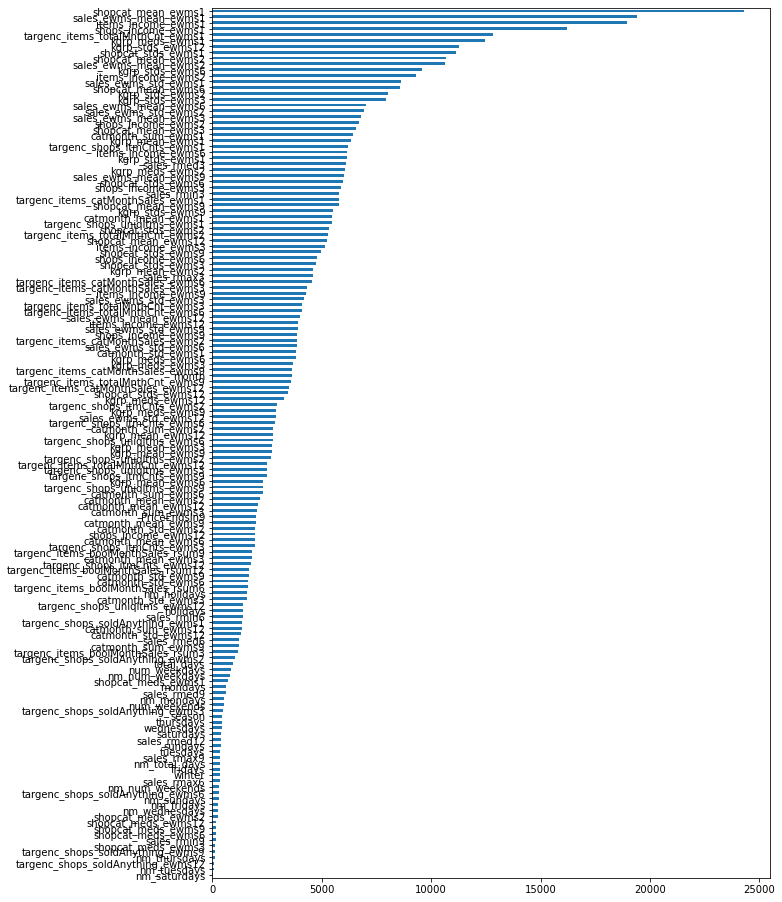

In [67]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [68]:
mod = xgb_model(num_boost_round=100, max_depth=20, eta=0.05, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-07
fit time: 659.8680379390717
Working on: 2015-08
fit time: 610.8701362609863
Working on: 2015-09
fit time: 631.6143527030945


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-07,1.369948,1.625527,1.283669,1.652215
2015-08,1.365315,1.648698,4.444940,6.181208
2015-09,1.330363,1.626088,3.322051,4.265980
FINAL,1.219198,1.507393,NaN,NaN


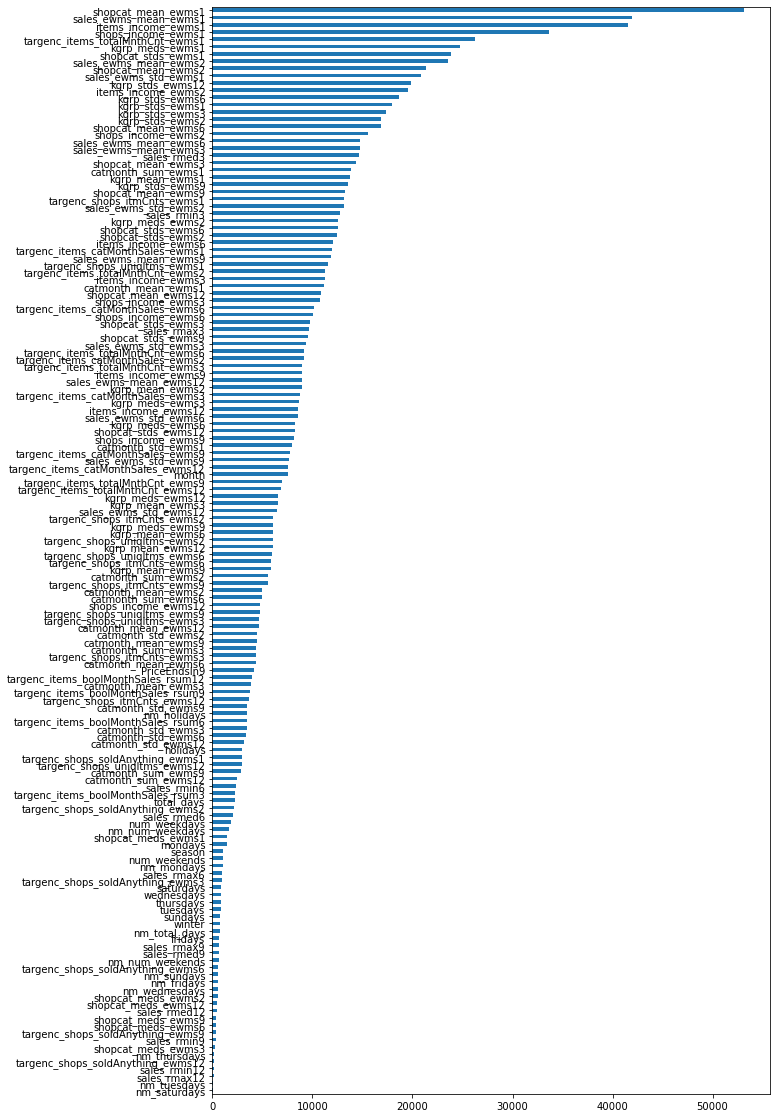

In [70]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,20))

In [ ]:
mod = xgb_model(num_boost_round=10, max_depth=20, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[18:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

In [ ]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

In [130]:
mod = xgb_model(num_boost_round=10, max_depth=5, eta=0.3, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 240.7158432006836
Working on: 2015-03
fit time: 186.88070583343506
Working on: 2015-04
fit time: 211.25960206985474
Working on: 2015-05
fit time: 193.431223154068
Working on: 2015-06
fit time: 206.49220299720764
Working on: 2015-07
fit time: 197.88093829154968
Working on: 2015-08
fit time: 193.6288628578186
Working on: 2015-09
fit time: 187.70809745788574


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.701304,1.943168,2.328799,2.846880
2015-03,1.684537,1.940587,3.331310,4.272039
2015-04,1.834680,2.135697,2.259251,2.987115
2015-05,1.843019,2.173407,0.955765,1.285634
2015-06,1.858923,2.217291,0.772617,1.031103
2015-07,1.833957,2.226622,0.934580,1.233407
2015-08,1.844068,2.267203,4.506256,6.265190
2015-09,1.893120,2.361013,3.566889,4.534363
FINAL,NaN,1.781608,NaN,NaN


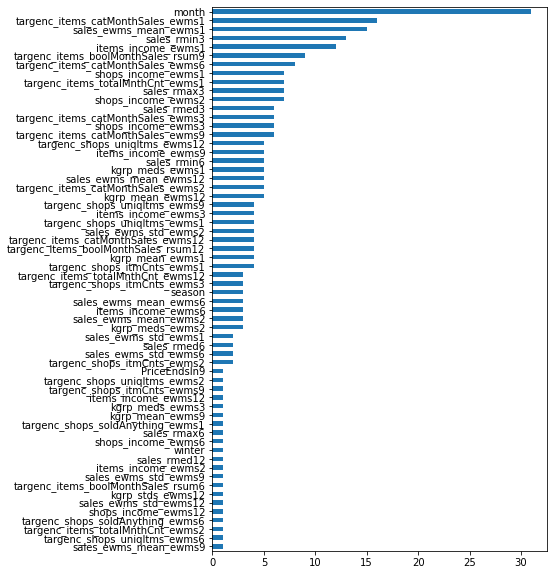

In [131]:
plot_feature_importances(res1.fitted_models['FINAL'])

In [132]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 257.58192110061646
Working on: 2015-03
fit time: 252.24047923088074
Working on: 2015-04
fit time: 217.02869033813477
Working on: 2015-05
fit time: 273.31816029548645
Working on: 2015-06
fit time: 231.00936222076416
Working on: 2015-07
fit time: 254.85765528678894
Working on: 2015-08
fit time: 232.20286393165588
Working on: 2015-09
fit time: 229.34297132492065


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.283909,1.468652,2.636248,3.229805
2015-03,1.260026,1.453291,3.373334,4.292949
2015-04,1.471642,1.715164,2.346080,3.039439
2015-05,1.518016,1.792258,1.267006,1.671467
2015-06,1.516075,1.815494,0.907714,1.147840
2015-07,1.501813,1.824641,1.000151,1.264827
2015-08,1.489372,1.839067,4.467694,6.215802
2015-09,1.459934,1.826240,3.458086,4.300968
FINAL,NaN,1.342613,NaN,NaN


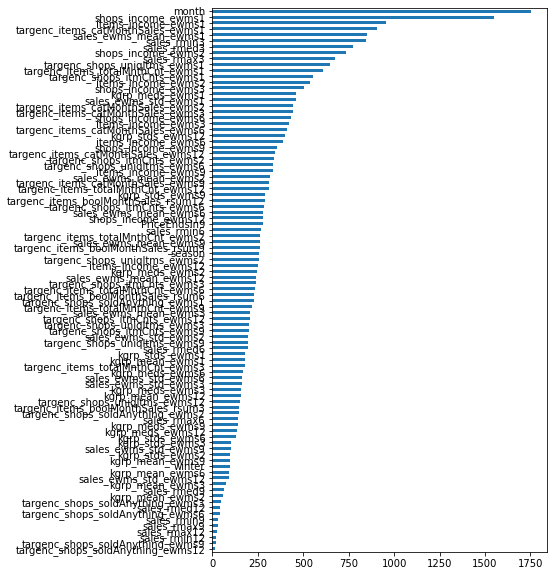

In [133]:
plot_feature_importances(res1.fitted_models['FINAL'])

CURRENT: 9/15/2020  9:36 AM

In [117]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 331.43427205085754
Working on: 2015-03
fit time: 399.5925860404968
Working on: 2015-04
fit time: 383.18187975883484
Working on: 2015-05
fit time: 376.1810419559479
Working on: 2015-06
fit time: 421.91879081726074
Working on: 2015-07
fit time: 392.85376143455505
Working on: 2015-08
fit time: 391.4495964050293
Working on: 2015-09
fit time: 372.18533515930176


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.248548,1.420628,2.588834,3.157592
2015-03,1.222169,1.401631,3.404206,4.291800
2015-04,1.444989,1.674068,2.336277,3.097752
2015-05,1.485564,1.742453,1.280459,1.689765
2015-06,1.483821,1.764540,1.083460,1.401605
2015-07,1.464256,1.763711,1.137009,1.507785
2015-08,1.456718,1.784372,4.447032,6.187923
2015-09,1.425182,1.768329,3.308374,4.236648
FINAL,NaN,1.308728,NaN,NaN


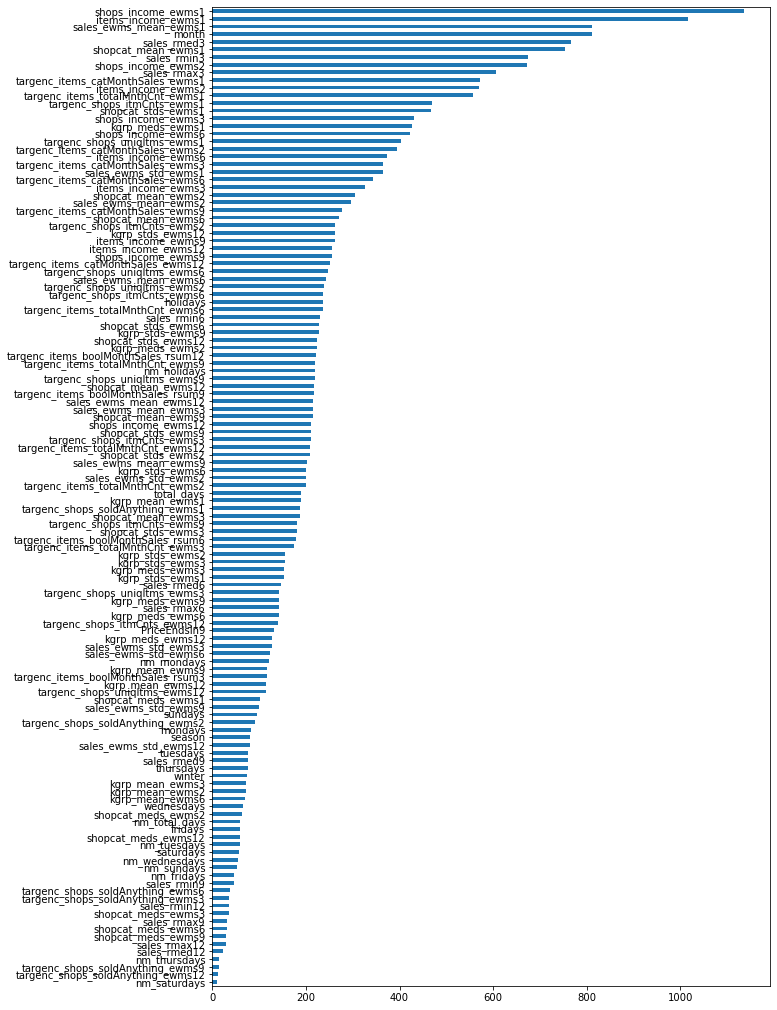

In [119]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,18))

CURRENT: 9/15/2020 11:39 AM

In [138]:
mod = xgb_model(num_boost_round=100, max_depth=15, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 438.4444601535797
Working on: 2015-03
fit time: 480.64026069641113
Working on: 2015-04
fit time: 461.1327886581421
Working on: 2015-05
fit time: 392.02765440940857
Working on: 2015-06
fit time: 407.981365442276
Working on: 2015-07
fit time: 428.2035024166107
Working on: 2015-08
fit time: 471.6797044277191
Working on: 2015-09
fit time: 819.1492056846619


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.154082,1.304447,3.170287,3.876685
2015-03,1.127046,1.283582,3.452789,4.345054
2015-04,1.366551,1.571110,2.313437,3.085937
2015-05,1.408500,1.635764,1.146238,1.504698
2015-06,1.406467,1.653049,1.156299,1.404629
2015-07,1.393304,1.661545,1.183060,1.497757
2015-08,1.386731,1.682920,4.489229,6.229823
2015-09,1.351952,1.660752,3.333350,4.166880
FINAL,NaN,1.230619,NaN,NaN


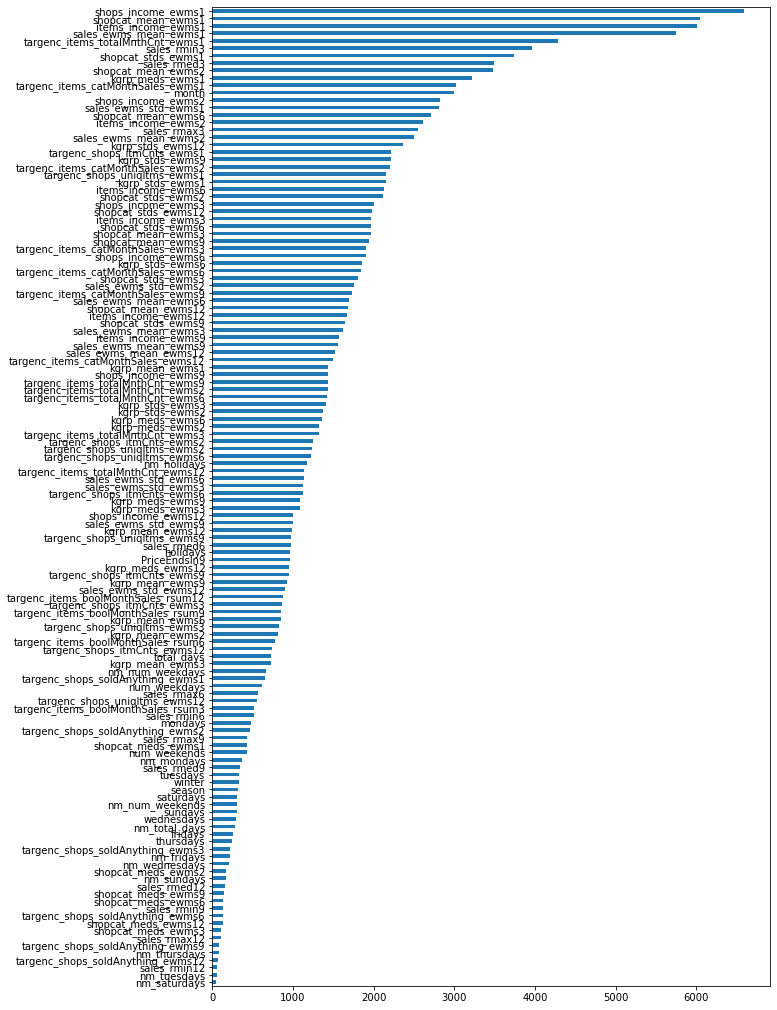

In [139]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,18))

In [140]:
mod = xgb_model(num_boost_round=100, max_depth=7, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 377.628778219223
Working on: 2015-03
fit time: 412.6697323322296
Working on: 2015-04
fit time: 368.80900382995605
Working on: 2015-05
fit time: 405.4402725696564
Working on: 2015-06
fit time: 397.71890330314636
Working on: 2015-07
fit time: 357.4279327392578
Working on: 2015-08
fit time: 401.62139654159546
Working on: 2015-09
fit time: 424.29852867126465


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.355449,1.546837,2.731111,3.332405
2015-03,1.341110,1.542142,3.358999,4.287728
2015-04,1.525540,1.773956,2.347996,3.087289
2015-05,1.574915,1.854620,1.084813,1.429064
2015-06,1.567902,1.872487,0.888193,1.168945
2015-07,1.546733,1.873199,1.111975,1.452903
2015-08,1.537910,1.892584,4.474555,6.228367
2015-09,1.515701,1.889782,3.397594,4.330368
FINAL,NaN,1.393036,NaN,NaN


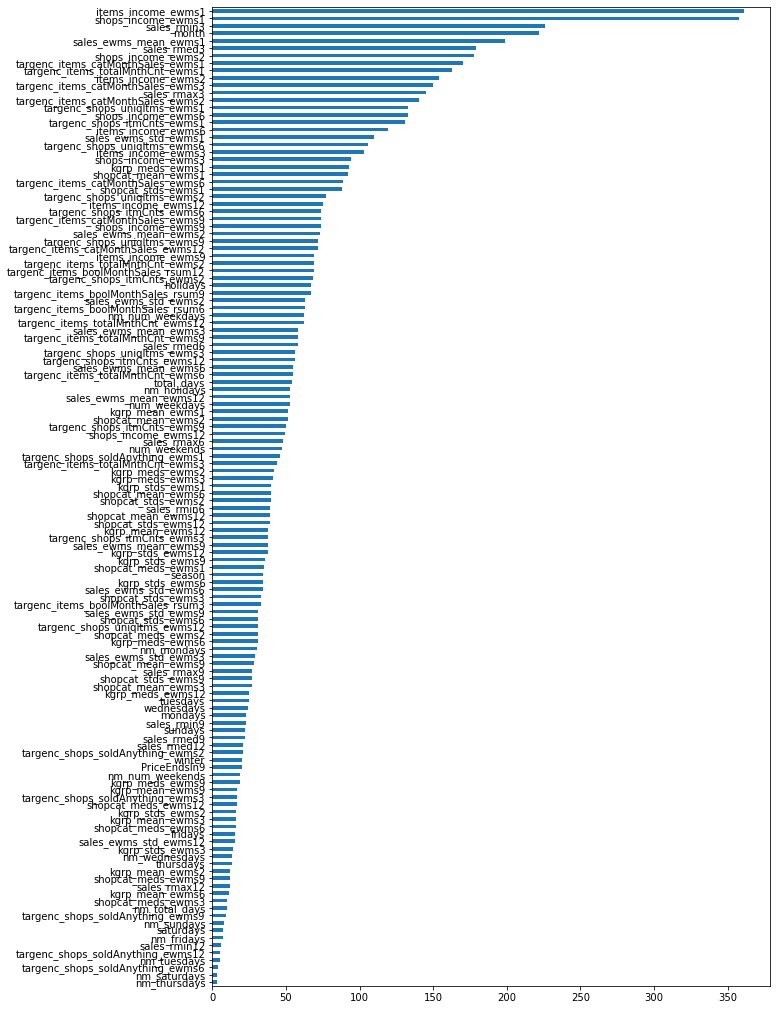

In [141]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,18))

In [87]:
mod = xgb_model(num_boost_round=400, max_depth=10, eta=0.025, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

Working on: 2015-02
fit time: 432.6012456417084
Working on: 2015-03
fit time: 433.9873993396759
Working on: 2015-04
fit time: 450.9647521972656
Working on: 2015-05
fit time: 432.766521692276
Working on: 2015-06
fit time: 450.0964856147766
Working on: 2015-07
fit time: 442.4120500087738
Working on: 2015-08
fit time: 450.6097424030304
Working on: 2015-09
fit time: 437.7254149913788


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.250490,1.423785,2.606914,3.180783
2015-03,1.222600,1.402932,3.373874,4.277575
2015-04,1.444143,1.674333,2.255743,3.007464
2015-05,1.485603,1.741603,1.254430,1.671159
2015-06,1.480441,1.761690,0.884496,1.161652
2015-07,1.469504,1.772977,1.004009,1.283048
2015-08,1.457326,1.784851,4.444510,6.186176
2015-09,1.425099,1.767434,3.455107,4.338690
FINAL,NaN,1.308271,NaN,NaN


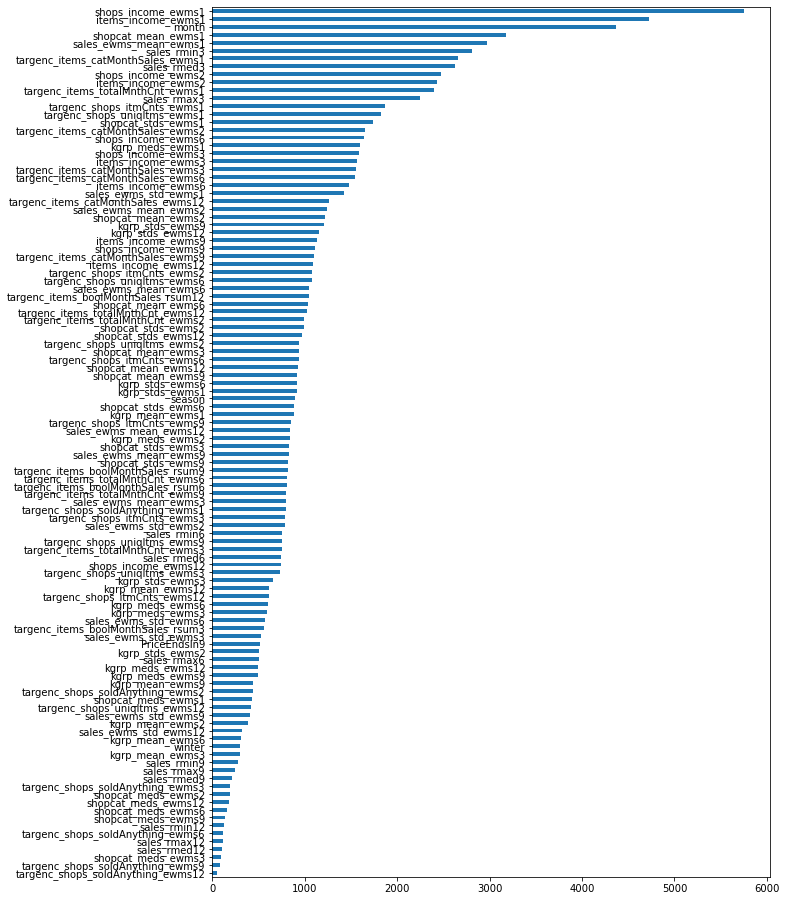

In [88]:
plot_feature_importances(res1.fitted_models['FINAL'], figsize=(10,16))

Current 9/14 2:54 PM

In [95]:
mod = xgb_model(num_boost_round=400, max_depth=20, eta=0.025, gpu_id=0, tree_method='gpu_hist')
res2 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res2.scores

Working on: 2015-02
fit time: 1195.9214506149292
Working on: 2015-03
fit time: 1255.6488552093506
Working on: 2015-04
fit time: 1295.7945988178253
Working on: 2015-05
fit time: 1305.2894928455353
Working on: 2015-06
fit time: 1301.2667002677917
Working on: 2015-07
fit time: 1291.8416521549225
Working on: 2015-08
fit time: 1331.1326098442078
Working on: 2015-09
fit time: 1346.488712310791


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.105578,1.245441,2.661563,3.253756
2015-03,1.079362,1.225605,3.423015,4.318212
2015-04,1.319548,1.507482,2.297931,3.043875
2015-05,1.364729,1.576191,1.367337,1.810832
2015-06,1.364691,1.599586,1.048649,1.301800
2015-07,1.355550,1.610482,1.001863,1.237439
2015-08,1.349680,1.629503,4.469579,6.216760
2015-09,1.313288,1.604187,3.460676,4.339902
FINAL,NaN,1.187509,NaN,NaN


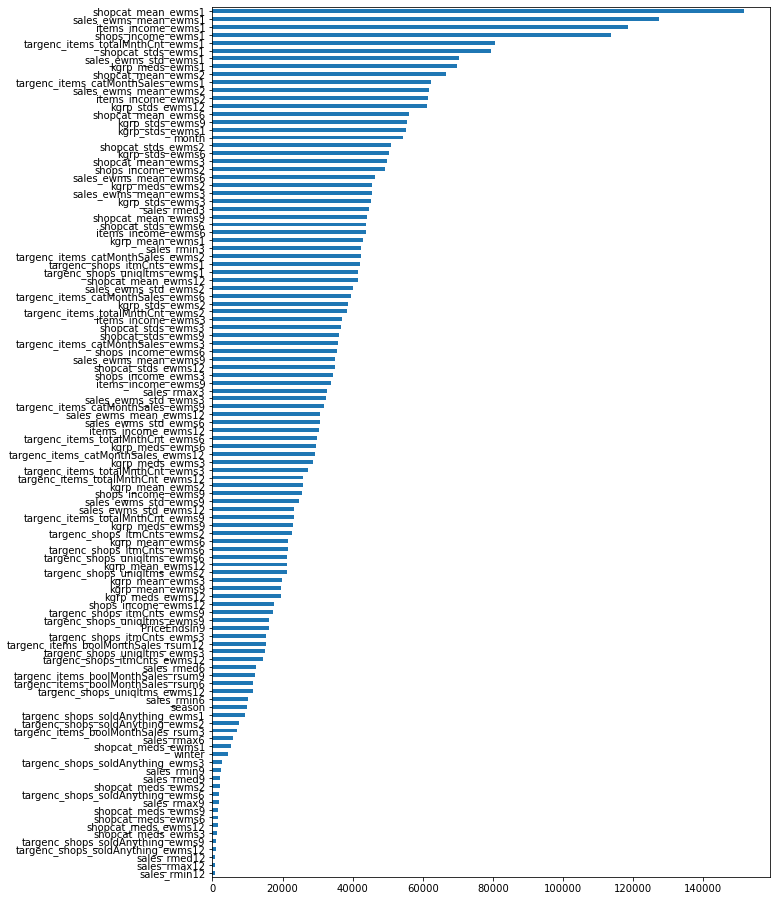

In [96]:
plot_feature_importances(res2.fitted_models['FINAL'], figsize=(10,16))

Try next

In [ ]:
mod = xgb_model(num_boost_round=600, max_depth=15, eta=0.025, gpu_id=0, tree_method='gpu_hist')
res2 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=18, fit_final=True)
res2.scores

Working on: 2015-08


In [ ]:
plot_feature_importances(res2.fitted_models['FINAL'], figsize=(10,16))

Afterwards, add cat_month interaction, and shop_month interaction

In [66]:
mod = xgb_model(num_boost_round=1000, max_depth=5, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1b = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1b.scores

Working on: 2015-02
fit time: 181.15861582756042
Working on: 2015-03
fit time: 203.82787656784058
Working on: 2015-04
fit time: 214.40518760681152
Working on: 2015-05
fit time: 201.30691242218018
Working on: 2015-06
fit time: 173.64247488975525
Working on: 2015-07
fit time: 183.80016493797302
Working on: 2015-08
fit time: 193.98032236099243
Working on: 2015-09
fit time: 190.69923663139343


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.323627,1.514163,2.698396,3.297503
2015-03,1.290173,1.487625,3.300296,4.229292
2015-04,1.481177,1.726054,2.320144,3.070441
2015-05,1.527040,1.802429,1.031910,1.369492
2015-06,1.522840,1.823597,0.818625,1.074788
2015-07,1.510749,1.835337,0.957976,1.262300
2015-08,1.501277,1.853372,4.536700,6.313715
2015-09,1.464064,1.830213,3.565494,4.359619
FINAL,NaN,1.343734,NaN,NaN


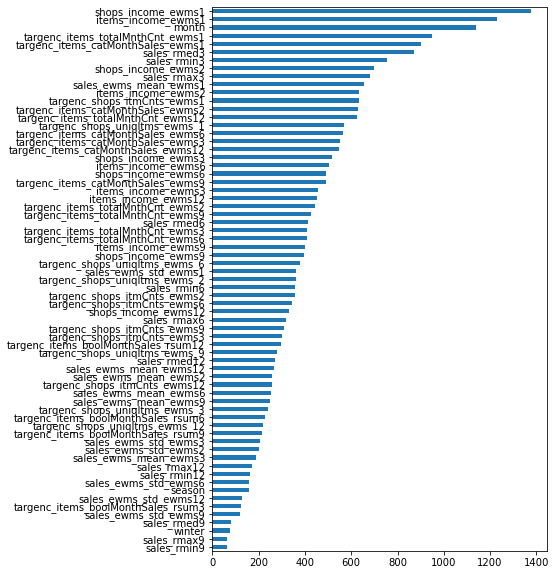

In [67]:
plot_feature_importances(res1b.fitted_models['FINAL'])

In [68]:
mod = xgb_model(num_boost_round=1000, max_depth=5, eta=0.1, gpu_id=0, tree_method='gpu_hist', min_child_weight=300)
res1c = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1c.scores

Working on: 2015-02
fit time: 175.4843988418579
Working on: 2015-03
fit time: 173.1269931793213
Working on: 2015-04
fit time: 180.67766547203064
Working on: 2015-05
fit time: 174.80038380622864
Working on: 2015-06
fit time: 163.84369945526123
Working on: 2015-07
fit time: 165.2700481414795
Working on: 2015-08
fit time: 187.09157872200012
Working on: 2015-09
fit time: 185.5876908302307


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,2.029611,2.313557,1.736646,2.114564
2015-03,1.984371,2.281921,3.366607,4.301185
2015-04,2.136295,2.478226,2.273411,3.022021
2015-05,2.166679,2.547007,1.039789,1.384144
2015-06,2.163867,2.576921,0.885728,1.193506
2015-07,2.188678,2.643895,1.028233,1.274155
2015-08,2.123760,2.609362,4.566716,6.359066
2015-09,2.229721,2.776063,3.469404,4.518860
FINAL,NaN,2.337364,NaN,NaN


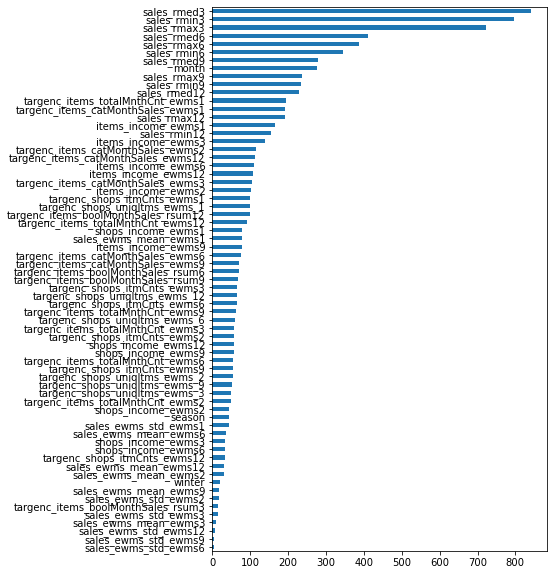

In [69]:
plot_feature_importances(res1c.fitted_models['FINAL'])

### Random Forrest

In [50]:
mod = RandomForestRegressor(n_estimators=5, max_depth=3, n_jobs=-1)
res11 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res11.scores

Working on: 2015-02
fit time: 157.65510964393616
Working on: 2015-03
fit time: 167.13195729255676
Working on: 2015-04
fit time: 162.0644872188568
Working on: 2015-05
fit time: 166.44589352607727
Working on: 2015-06
fit time: 157.0563473701477
Working on: 2015-07
fit time: 161.12535333633423
Working on: 2015-08
fit time: 167.23387360572815
Working on: 2015-09
fit time: 176.44227600097656


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,2.014472,2.292852,2.153181,2.631210
2015-03,1.988152,2.278655,3.323835,4.257576
2015-04,2.103979,2.439763,2.359528,3.142759
2015-05,2.178823,2.557594,1.019679,1.318083
2015-06,2.132482,2.536802,0.873650,1.108336
2015-07,2.135277,2.582634,1.087771,1.403946
2015-08,2.125936,2.612057,4.630965,6.445904
2015-09,2.369354,2.950731,3.557495,4.639217
FINAL,NaN,2.337687,NaN,NaN


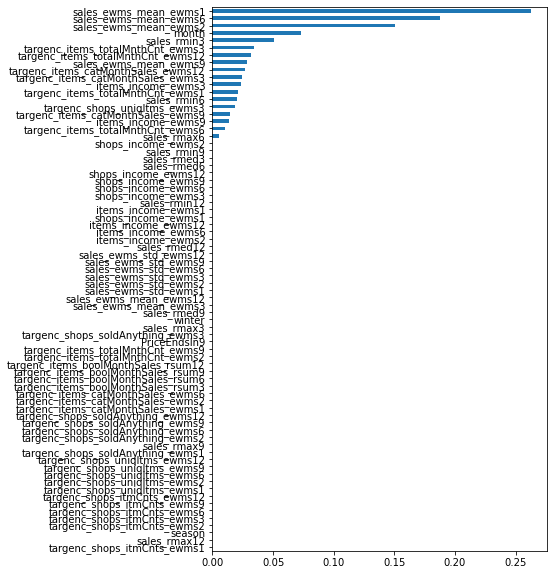

In [51]:
plot_feature_importances(res11.fitted_models['FINAL'])

In [103]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
res5 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res5.scores

Working on: 2015-02
fit time: 1519.3715209960938
Working on: 2015-03
fit time: 1535.786041021347
Working on: 2015-04
fit time: 1463.752594947815
Working on: 2015-05
fit time: 1471.0660820007324
Working on: 2015-06
fit time: 1479.5447058677673
Working on: 2015-07
fit time: 1514.2314159870148
Working on: 2015-08
fit time: 1505.886890888214
Working on: 2015-09
fit time: 1483.0496306419373


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,1.791767,2.035318,2.021579,2.465638
2015-03,1.764429,2.025564,3.324435,4.220675
2015-04,1.901200,2.201253,2.345511,3.056807
2015-05,1.968547,2.309693,1.142206,1.488297
2015-06,1.951029,2.322303,0.801220,1.066336
2015-07,1.943119,2.349970,0.986363,1.301993
2015-08,1.931048,2.369730,4.557945,6.345695
2015-09,2.017162,2.513729,3.588552,4.623948
FINAL,NaN,1.966828,NaN,NaN


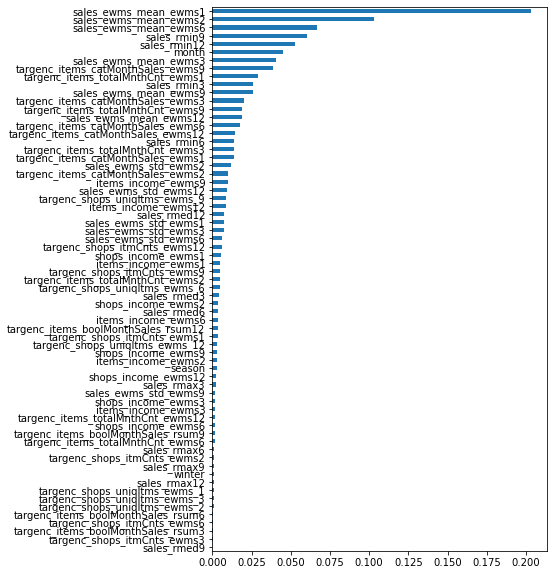

In [104]:
plot_feature_importances(res5.fitted_models['FINAL'])

### Linear Model

In [59]:
mod = LinearRegression()
res6 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res6.scores

Working on: 2015-02
fit time: 65.78097200393677
Working on: 2015-03
fit time: 54.72403526306152
Working on: 2015-04
fit time: 67.39345169067383
Working on: 2015-05
fit time: 69.66224312782288
Working on: 2015-06
fit time: 63.36846327781677
Working on: 2015-07
fit time: 58.59580135345459
Working on: 2015-08
fit time: 72.33271074295044
Working on: 2015-09
fit time: 73.44256091117859


,PreInSampleRMSE,inSampleRMSE,PreOutSampleRMSE,outSampleRMSE
2015-02,2.025938,2.312923,1.540135,1.862554
2015-03,2.009423,2.311610,3.437756,4.396273
2015-04,2.144183,2.493302,2.456698,3.252347
2015-05,2.211525,2.605925,1.119091,1.436054
2015-06,2.201265,2.630486,0.753052,0.965527
2015-07,2.189368,2.654347,0.929130,1.194665
2015-08,2.182389,2.687475,4.601868,6.404143
2015-09,2.447985,3.058120,3.768735,4.639154
FINAL,NaN,2.557398,NaN,NaN


In [60]:
res6.fitted_models['FINAL'].coef_

array([ 3.12574273e+00, -1.75789875e+01,  3.13284334e+01, -4.30184668e+01,
        4.57600290e+01, -1.81711770e+01, -6.86776623e-01,  5.97470903e+00,
       -1.91067922e+01,  6.53419483e+01, -1.07164011e+02,  5.51536610e+01,
       -1.88443690e-05,  1.25016372e-04, -2.09950996e-04,  3.05900372e-04,
       -3.37809208e-04,  1.35138353e-04,  4.35773195e-07, -1.96074045e-06,
        2.25377399e-06, -5.30107211e-07, -3.08494377e-06,  2.87819596e-06,
       -3.77551385e-02, -3.77551230e-02, -3.77551372e-02, -3.77551324e-02,
       -2.69782901e-02, -2.69782920e-02, -2.69782805e-02, -2.69782847e-02,
       -1.62014577e-02, -1.62014613e-02, -1.62014612e-02, -1.62014613e-02,
       -1.19651198e-03,  9.95776028e-03, -2.17316180e-02,  5.32102154e-02,
       -7.67922067e-02,  3.66218938e-02,  3.42097840e-03, -3.15958923e-02,
        7.03021668e-02, -1.70186007e-01,  2.49755211e-01, -1.21724269e-01,
       -1.25173120e-04,  1.27107704e-03, -2.19753938e-03,  1.60137919e-03,
        1.85096965e-04, -

Parameter hypertuning:
- num_boost_rounds: 10 - 500
- max_depth: 5 - 30
- eta : 0.5 - 0.01

# Preparing Submission

In [ ]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1, gpu_id=0, tree_method='gpu_hist')
res1 = rolling_cross_validation(mod, months[13:], num_lagged_values=0, num_stack_months=12, fit_final=True)
res1.scores

In [126]:
def merge_pred_with_test(prediction, fill_val=0, pred_col='item_cnt_month'):
    assert pred_col in prediction.columns, f'Couldnt find {pred_col}'
    data_fol = 'data'
    test = pd.read_csv(os.path.join(data_fol, 'test.csv'))
    merged =  pd.merge(test, prediction, on=['shop_id', 'item_id'], how='left').fillna(fill_val)
    if pred_col != 'item_cnt_month':
        merged = merged.rename(columns={pred_col:'item_cnt_month'})
    return merged.set_index('ID')['item_cnt_month']

In [131]:
Xt, Yt, _ = get_single_month_XY(months[-1])

In [132]:
y_pred = pd.DataFrame({'item_cnt_month':res1.fitted_models['FINAL'].predict(Xt)}, index=Xt.index)
y_sub = merge_pred_with_test(y_pred)

In [133]:
y_sub.to_csv('xgb_depth10_rounds100_eta0p1_monthDecompFeatures.csv')

In [134]:
np.clip(0, 20, y_sub).to_csv('xgb_depth10_rounds100_eta0p1_monthDecompFeatures_clipped20.csv')

# TODO
* reduce size of ints and floats
* test clip in rolling CV
* add k-nn features for stores
* tune more xgb params
* stacking